In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import MinMaxScaler
import optuna

from sklearn.preprocessing import LabelEncoder
%matplotlib inline

In [2]:
train = pd.read_csv('/kaggle/input/laptop-price-prediction/laptops_train.csv', sep = ',')
test = pd.read_csv('/kaggle/input/laptop-price-prediction/laptops_test.csv', sep = ',')

print(f'Train shape: {train.shape} \nTest shape: {test.shape}')

Train shape: (977, 13) 
Test shape: (325, 13)


In [3]:
train.head(7)

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,NaN,1.37kg,11912523.48
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,NaN,1.34kg,7993374.48
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,NaN,1.86kg,5112900.00
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,NaN,1.83kg,22563005.40
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,NaN,1.37kg,16037611.20
5,Acer,Aspire 3,Notebook,"15.6""",1366x768,AMD A9-Series 9420 3GHz,4GB,500GB HDD,AMD Radeon R5,Windows,10,2.1kg,3556800.00
6,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.2GHz,16GB,256GB Flash Storage,Intel Iris Pro Graphics,Mac OS,X,2.04kg,19028613.24


In [4]:
# concatenate the 2 dataset into 1 to analyse all the dataset and preprocessing all of them
# From 0 -> 976 is train set, others belong to test set

dataset = pd.concat([train, test])
dataset = dataset.reset_index(drop = True)
dataset.shape

(1302, 13)

In [5]:
# Statistics overview of the dataset
dataset.describe(include = 'all')

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price
count,1302,1302,1302,1302,1302,1302,1302,1302,1302,1302,1132,1302,1.302000e+03
unique,19,617,6,18,40,118,9,38,110,7,4,179,NaN
top,Dell,XPS 13,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,Windows,10,2.2kg,NaN
freq,297,30,727,664,507,190,619,412,281,1124,1071,121,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9.987213e+06
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.215746e+06
min,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.547208e+06
25%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.326308e+06
50%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.687484e+06
75%,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.321198e+07


In [6]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Manufacturer              1302 non-null   object 
 1   Model Name                1302 non-null   object 
 2   Category                  1302 non-null   object 
 3   Screen Size               1302 non-null   object 
 4   Screen                    1302 non-null   object 
 5   CPU                       1302 non-null   object 
 6   RAM                       1302 non-null   object 
 7    Storage                  1302 non-null   object 
 8   GPU                       1302 non-null   object 
 9   Operating System          1302 non-null   object 
 10  Operating System Version  1132 non-null   object 
 11  Weight                    1302 non-null   object 
 12  Price                     1302 non-null   float64
dtypes: float64(1), object(12)
memory usage: 132.4+ KB


In [7]:
# Checking for the number null values in each column:
dataset.isna().sum()

Manufacturer                  0
Model Name                    0
Category                      0
Screen Size                   0
Screen                        0
CPU                           0
RAM                           0
 Storage                      0
GPU                           0
Operating System              0
Operating System Version    170
Weight                        0
Price                         0
dtype: int64

In [8]:
data = dataset.copy()

In [9]:
# function for plotting the mean value of the continuous data according to the discrete data

def compare_means(data, discrete, continuous):
    group = data.groupby([discrete], as_index = False)[continuous].mean().reset_index(drop = True)
    plt.subplots(figsize = (10, 6))
    sns.barplot(x = group[discrete], y = group[continuous], palette = 'Blues')
    plt.show()

# EDA

#### Manufacturer

In [10]:
# Count the number of each values of the column 
data['Manufacturer'].value_counts()

Dell         297
Lenovo       297
HP           274
Asus         157
Acer         103
MSI           54
Toshiba       48
Apple         21
Samsung        9
Razer          7
Mediacom       7
Microsoft      6
Xiaomi         4
Vero           4
Chuwi          3
Google         3
Fujitsu        3
LG             3
Huawei         2
Name: Manufacturer, dtype: int64

In [11]:
data['Manufacturer'].describe()

count     1302
unique      19
top       Dell
freq       297
Name: Manufacturer, dtype: object

In [12]:
data['Manufacturer'].unique()

array(['Apple', 'HP', 'Acer', 'Asus', 'Dell', 'Lenovo', 'Chuwi', 'MSI',
       'Microsoft', 'Toshiba', 'Huawei', 'Xiaomi', 'Vero', 'Razer',
       'Mediacom', 'Samsung', 'Google', 'Fujitsu', 'LG'], dtype=object)

Lets see the plot of each manufacturer on the entire of the data(all the train and test set):


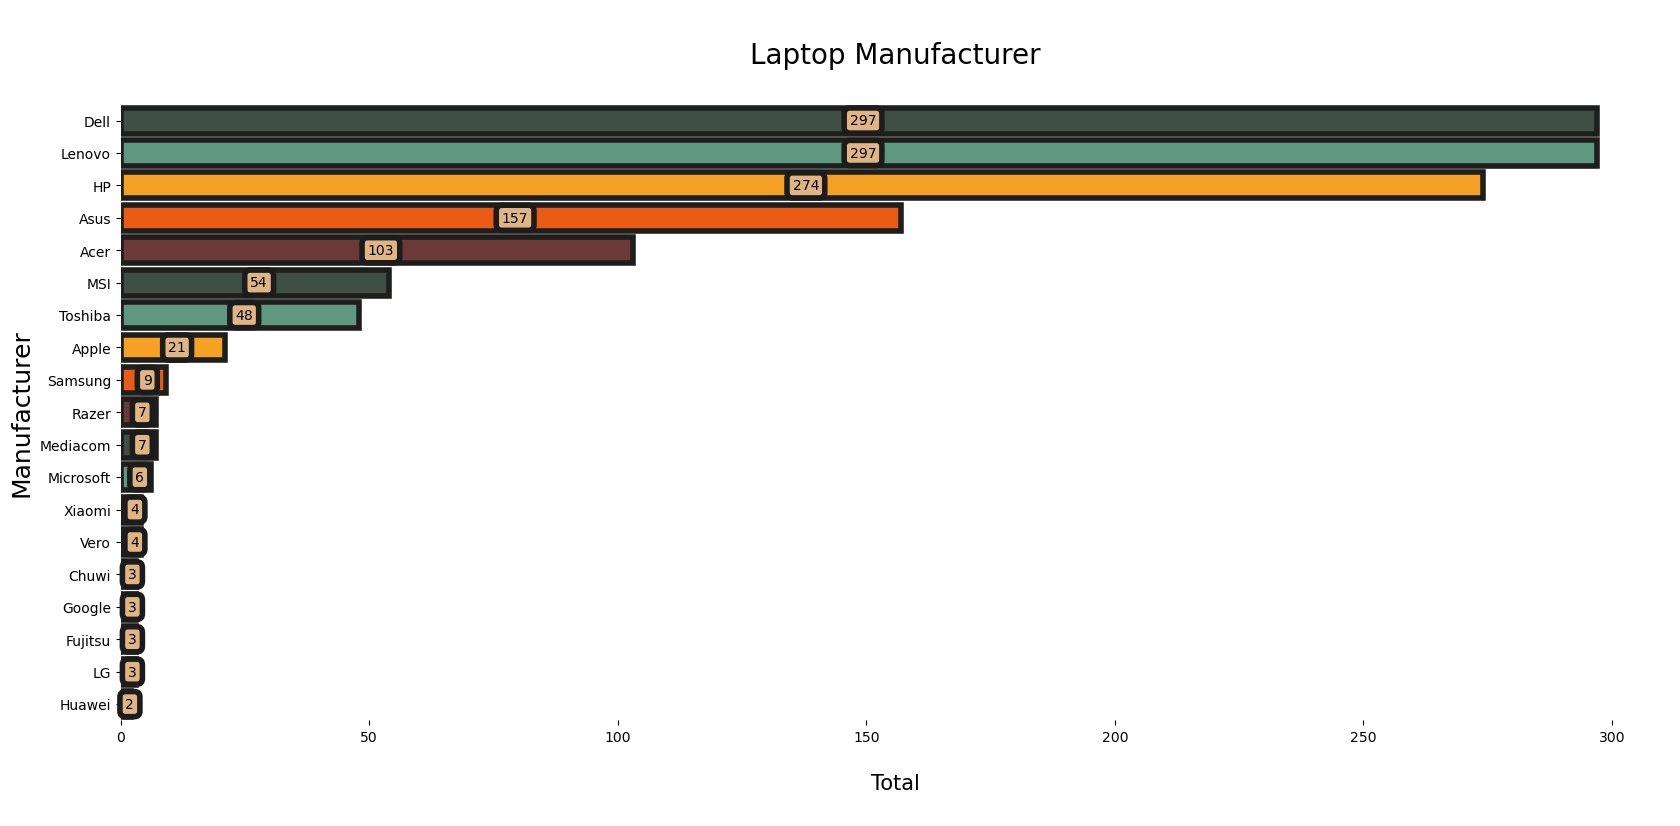

In [13]:
print('Let''s see the plot of each manufacturer on the entire of the data(all the train and test set):')
plt.subplots(figsize = (20, 8))
p = sns.countplot(y = data['Manufacturer'], order = data['Manufacturer'].value_counts().index, palette=["#3f4f45","#5e9880","#f5a126","#ea5b17","#6c3938"],
              saturation = 1, edgecolor = '#1e1e1c', linewidth = 4)

p.axes.set_xlabel('\nTotal\n', fontsize = 15)
p.axes.set_ylabel('Manufacturer', fontsize = 18)
p.axes.set_title('\nLaptop Manufacturer\n', fontsize = 20)
p.axes.set_yticklabels(p.get_yticklabels(), rotation = 0)
    
for container in p.containers:
    p.bar_label(container,label_type="center",padding=3,size=10,color="black",rotation=0,
    bbox={"boxstyle": "round", "pad": 0.4, "facecolor": "#e0b583", "edgecolor": "#1c1c1c", "linewidth" : 4, "alpha": 1})
    
sns.despine(left = True, bottom = True)  # To change the boundery of the plot
plt.show()

Boxplot for price distribution for each manufacturer: 


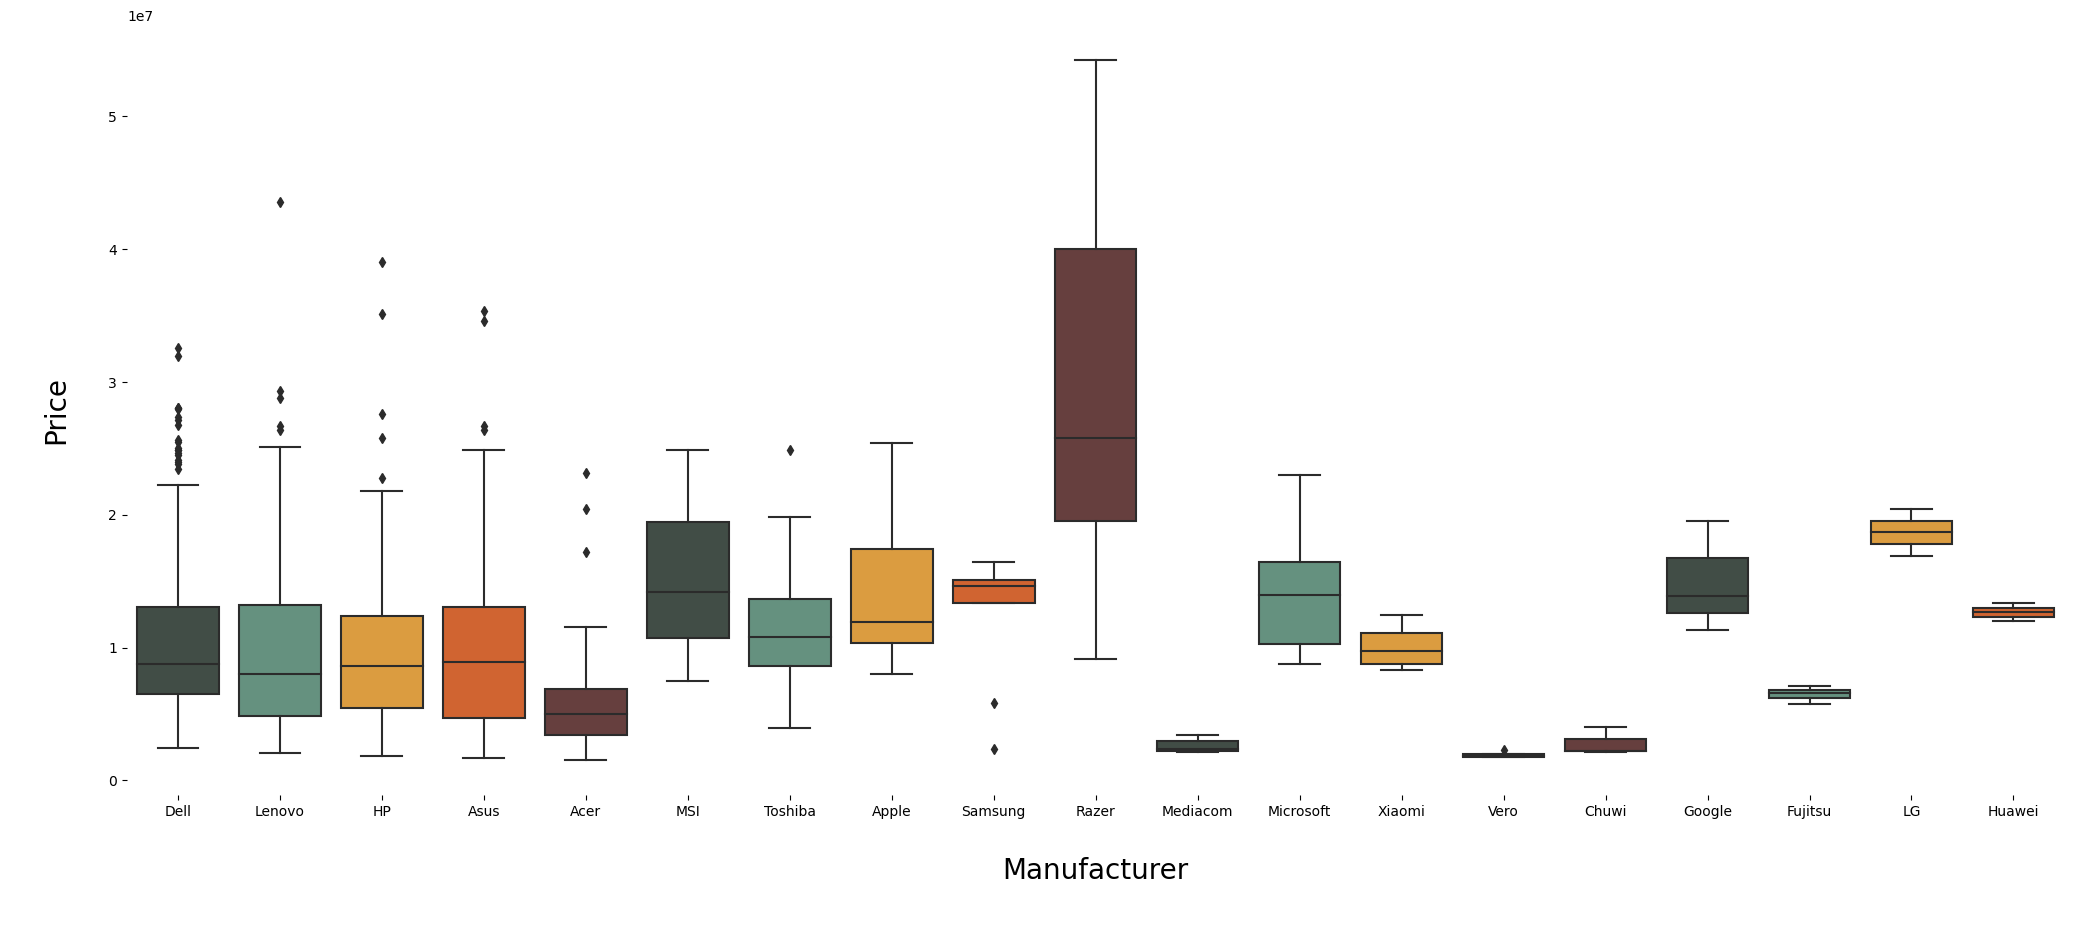

In [14]:
print('Boxplot for price distribution for each manufacturer: ')
plt.subplots(figsize = (25, 10))
p = sns.boxplot(x = data['Manufacturer'],y = data['Price'], order = data['Manufacturer'].value_counts().index, 
                palette=["#3f4f45","#5e9880","#f5a126","#ea5b17","#6c3938"])

p.axes.set_xlabel('\nManufacturer\n', fontsize = 20)
p.axes.set_ylabel('\nPrice\n', fontsize = 20)

sns.despine(left = True, bottom = True)
plt.show()

### Model Name 

In [15]:
data['Model Name'].describe()

count       1302
unique       617
top       XPS 13
freq          30
Name: Model Name, dtype: object

In [16]:
data['Model Name'].value_counts().index

Index(['XPS 13', 'Inspiron 3567', '250 G6', 'Legion Y520-15IKBN',
       'Vostro 3568', 'Inspiron 5570', 'ProBook 450', 'Alienware 17',
       'Inspiron 5567', 'Satellite Pro',
       ...
       'FX553VD-DM627T (i5-7300HQ/8GB/1TB', 'Thinkpad P71',
       'V330-15IKB (i3-7130U/4GB/128GB/FHD/W10)', 'Spin SP111-31',
       '15-bw007nv (A10-9620P/6GB/128GB/Radeon', 'SmartBook 130',
       'A541NA-GO342 (N3350/4GB/500GB/Linux)',
       '17-X047na (i3-6006U/8GB/1TB/W10)',
       'V310-15ISK (i5-6200U/4GB/1TB/FHD/No',
       '15-cd005nv (A9-9420/6GB/256GB/Radeon'],
      dtype='object', length=617)

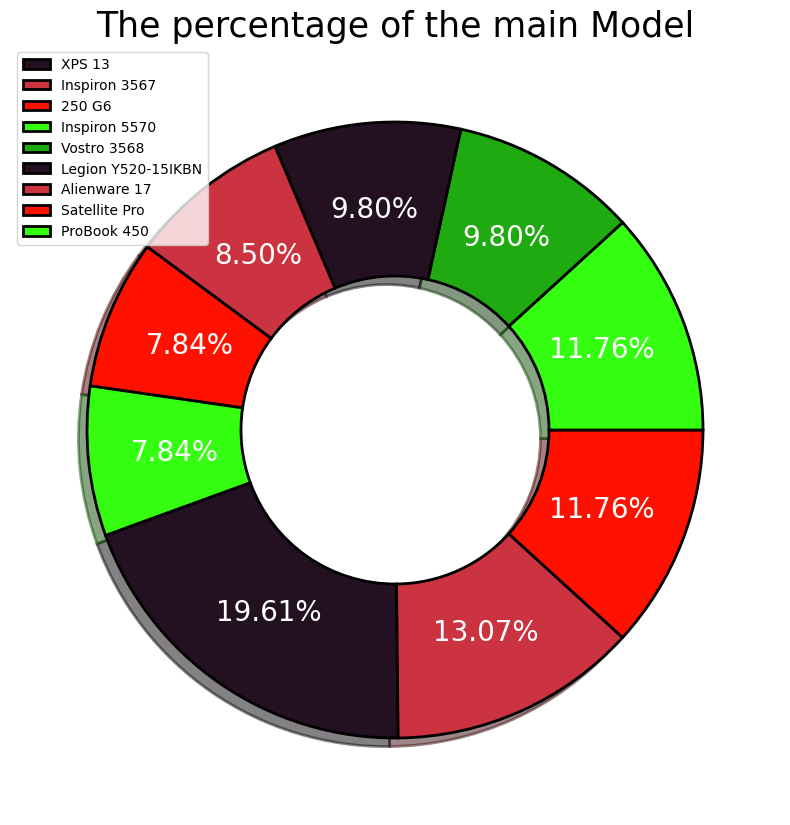

In [17]:
plt.subplots(figsize = (12, 10))

labels = "XPS 13","Inspiron 3567","250 G6","Inspiron 5570","Vostro 3568","Legion Y520-15IKBN", "Alienware 17", "Satellite Pro", "ProBook 450", "Latitude 5580"
size = 0.5
wedges, texts, autotexts = plt.pie([data['Model Name'].value_counts()[0],
                                    train["Model Name"].value_counts().values[1],
                                    train["Model Name"].value_counts().values[2],
                                    train["Model Name"].value_counts().values[3],
                                    train["Model Name"].value_counts().values[5],
                                    train["Model Name"].value_counts().values[6],
                                    train["Model Name"].value_counts().values[7],
                                    train["Model Name"].value_counts().values[8],
                                    train["Model Name"].value_counts().values[9],
                                    ],
                                    colors = ['#231122', '#cb3340', '#ff1100', '#34ff11', '#20aa11'],
                                    autopct= "%.2f%%", 
                                    pctdistance = .72,
                                    shadow = True,
                                    textprops = dict(size = 20, color = 'white'),
                                    wedgeprops = dict(width = size, edgecolor = 'black', linewidth = 2),
                                    explode = (0,0,0,0,0,0,0,0,0),
                                    startangle = -160)
plt.legend(wedges, labels, loc = 'best')
plt.title('The percentage of the main Model', fontsize = 25)
plt.show()

### Category 

In [18]:
data['Category'].describe()

count         1302
unique           6
top       Notebook
freq           727
Name: Category, dtype: object

In [19]:
data['Category'].value_counts()

Notebook              727
Gaming                205
Ultrabook             196
2 in 1 Convertible    120
Workstation            29
Netbook                25
Name: Category, dtype: int64

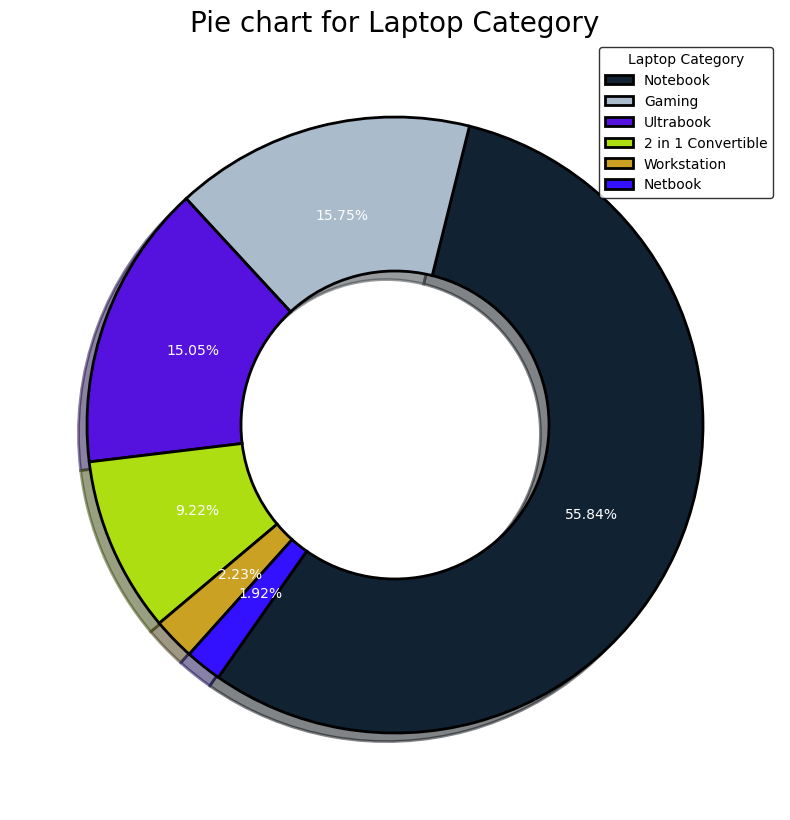

In [20]:
plt.subplots(figsize = (12, 10))

labels = 'Notebook', 'Gaming', 'Ultrabook', '2 in 1 Convertible', 'Workstation','Netbook'
size = 0.5

wedges, texts, autotexts = plt.pie([
    data['Category'].value_counts()[0],
    data['Category'].value_counts()[1],
    data['Category'].value_counts()[2],
    data['Category'].value_counts()[3],
    data['Category'].value_counts()[4],
    data['Category'].value_counts()[5]
    ],
    explode = (0,0,0,0,0,0),
    shadow = True,
    colors = ['#112233', '#aabbcc', '#5511dd', '#acde12', '#cba123', '#3311ff'],
    autopct = '%.2f%%',
    pctdistance = 0.7,
    textprops = dict(size = 10, color = 'white'),
    wedgeprops = dict(width = size, edgecolor = 'black', linewidth = 2),
    startangle = -125)

plt.legend(wedges, labels, loc = 'best', title = 'Laptop Category', edgecolor = 'black')
plt.title('Pie chart for Laptop Category', fontsize = 20)
plt.show()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  # Remove the CWD from sys.path while we load stuff.


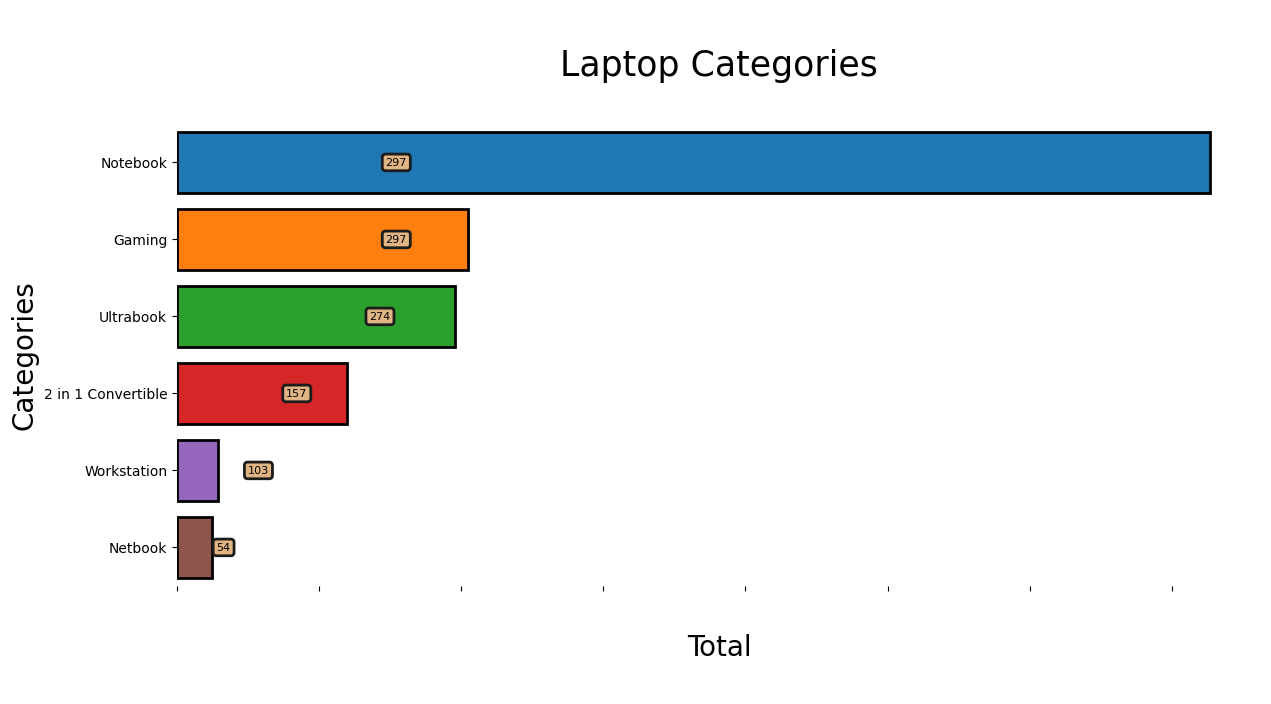

In [21]:
# Box plot for different laptop categories
# The size of the plot also matter the size of the bar label (the number annotation of the number of the laptop)

plt.subplots(figsize = (14, 6))
p = sns.countplot(y = data['Category'], order = data['Category'].value_counts().index, saturation = 1, edgecolor = 'black', linewidth = 2)

p.axes.set_title("\nLaptop Categories\n",fontsize=25)
p.axes.set_ylabel("Categories",fontsize=20)
p.axes.set_xlabel("\nTotal\n",fontsize=20)
p.axes.set_xticklabels(p.get_xticklabels(),rotation = 0)

for contaier in p.containers:
    p.bar_label(container, label_type= 'center', color = 'black', rotation = 0,padding=6,size=8, 
                bbox = {'boxstyle':'round', 'facecolor' : '#e0b583', 'edgecolor' : '#1c1c1c', "linewidth" : 2, "alpha": 1})

sns.despine(left = True, bottom = True)
plt.show()

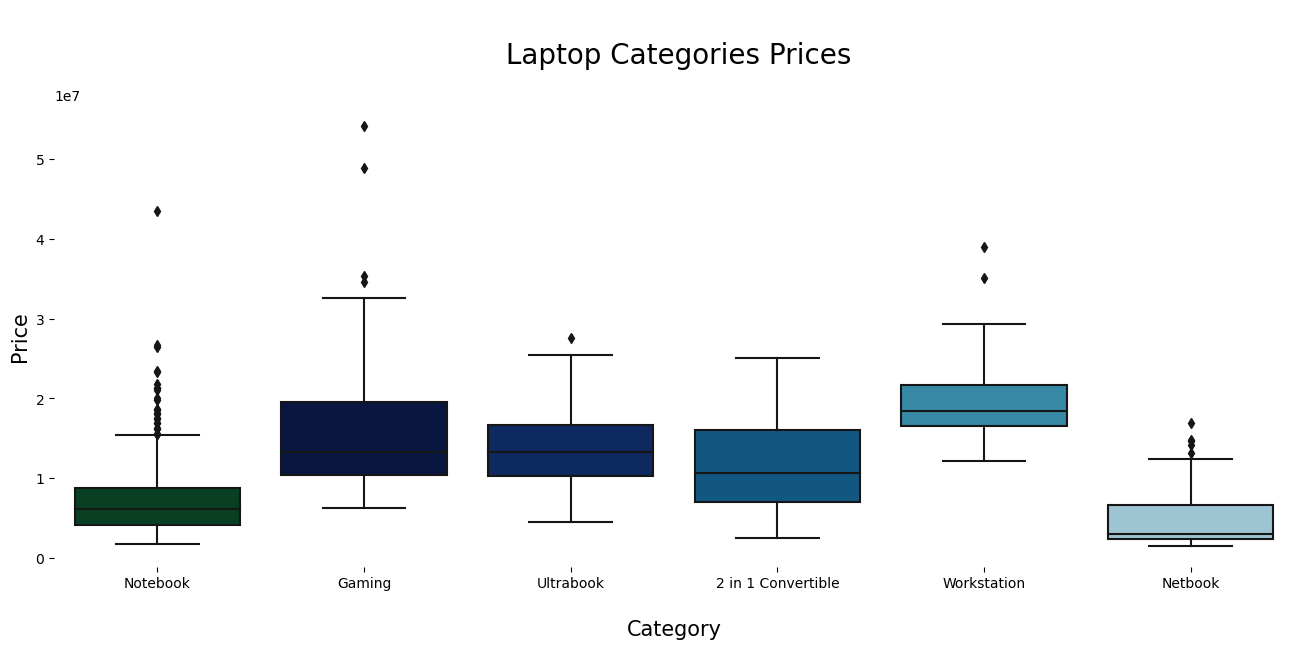

In [22]:
# Box plot for the distribution of the Laptop Categories to the Price
plt.subplots(figsize = (16, 6))

p = sns.boxplot(x = data['Category'], y = data['Price'], order = data['Category'].value_counts().index, palette = 'ocean')

p.axes.set_title("\n Laptop Categories Prices\n",fontsize=20)
p.axes.set_xlabel("\nCategory",fontsize=15)
p.axes.set_ylabel("Price",fontsize=15)

sns.despine(left = True, bottom = True)
plt.show()

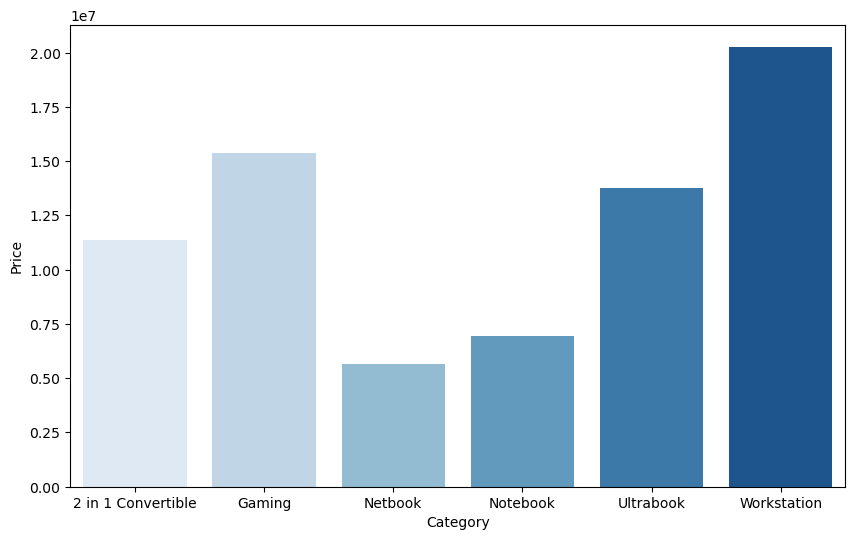

In [23]:
compare_means(data, 'Category', 'Price')

### Operating System

In [24]:
data['Operating System'].describe()

count        1302
unique          7
top       Windows
freq         1124
Name: Operating System, dtype: object

In [25]:
data['Operating System'].value_counts().values[0]

1124

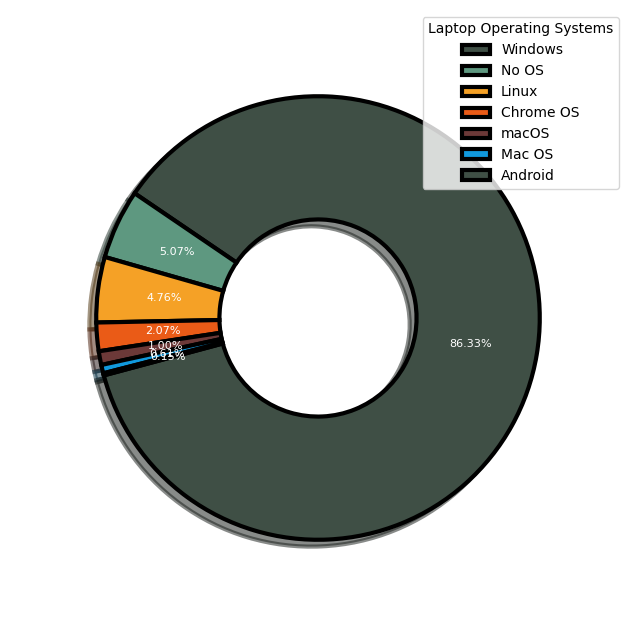

In [26]:
plt.subplots(figsize = (12, 8))
label = 'Windows', 'No OS', 'Linux', 'Chrome OS', 'macOS', 'Mac OS', 'Android'
size = 0.5
wedges, texts, autotexts = plt.pie(
             [data['Operating System'].value_counts()[0],
             data['Operating System'].value_counts()[1],
             data['Operating System'].value_counts()[2],
             data['Operating System'].value_counts()[3],
             data['Operating System'].value_counts()[4],
             data['Operating System'].value_counts()[5],
             data['Operating System'].value_counts()[6]],
             shadow = True, 
             pctdistance=0.7,
             textprops = dict(color = 'white', size =8),
             colors = ["#3f4f45","#5e9880","#f5a126","#ea5b17","#6c3938", '#1199dd'],
             radius = .9,
             autopct = '%.2f%%',
             wedgeprops = dict(edgecolor = 'black', linewidth = 3, width = size),
             startangle = -165,
             explode = (0,0,0,0,0,0,0)
)

plt.legend(wedges, label,title = 'Laptop Operating Systems', loc = 'best')
plt.show()

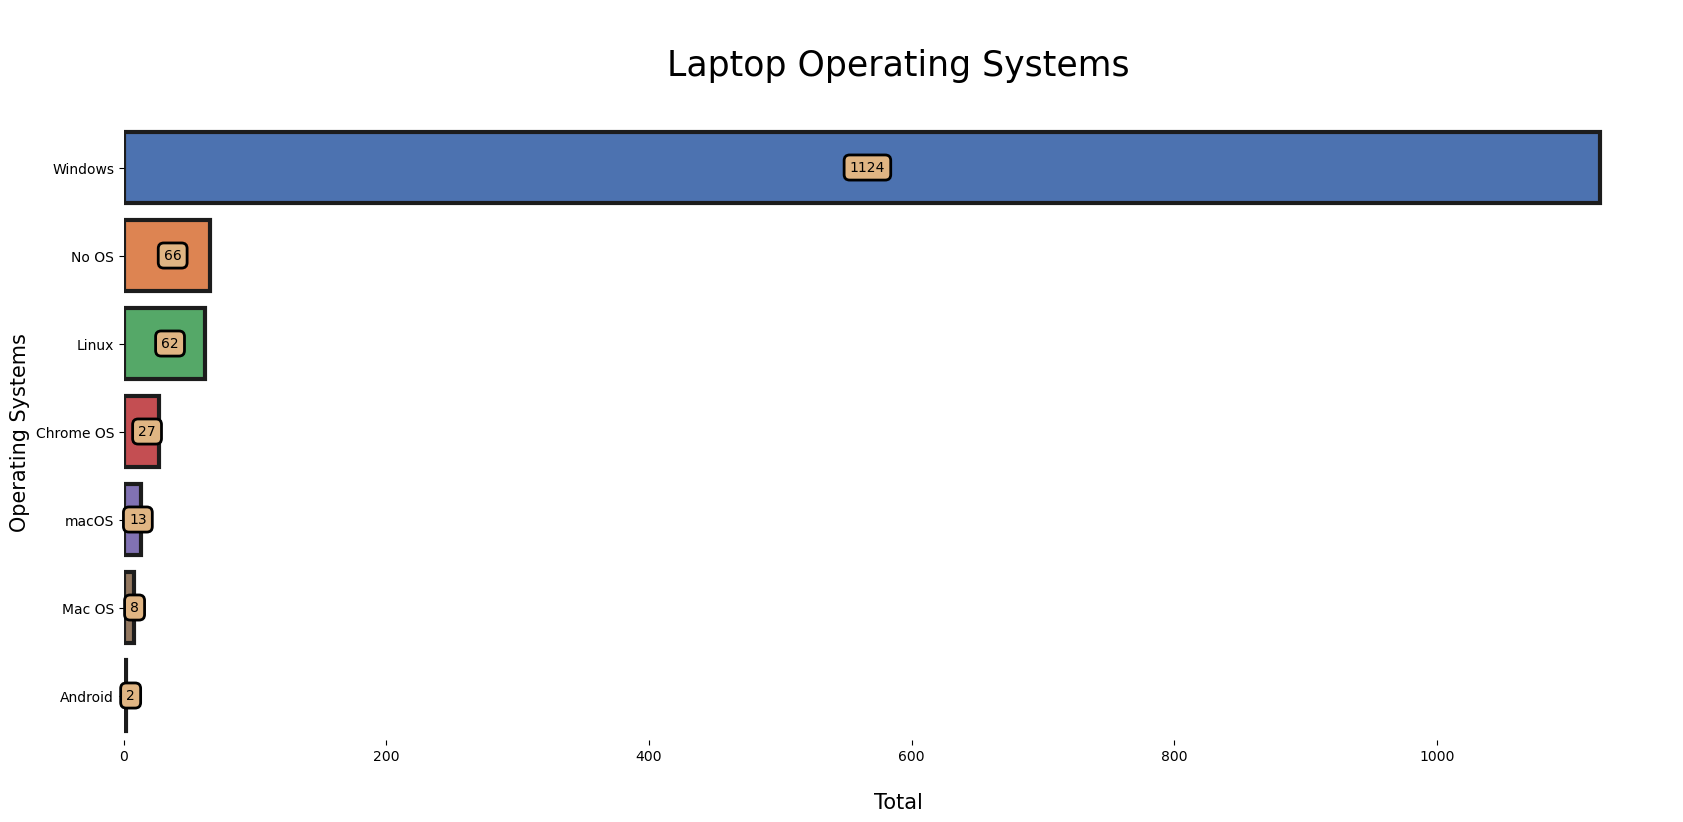

In [27]:
plt.subplots(figsize = (20, 8))

p = sns.countplot(y = data['Operating System'], order = data['Operating System'].value_counts().index, palette = 'deep', 
                  saturation = 1, edgecolor = '#1c1c1c', linewidth = 3)

p.axes.set_title("\nLaptop Operating Systems\n",fontsize=25)
p.axes.set_ylabel("Operating Systems",fontsize=15)
p.axes.set_xlabel("\nTotal",fontsize=15)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)

for container in p.containers:
    p.bar_label(container, label_type='center', padding=4, size = 10, color = 'black',
                bbox = {'boxstyle' : 'round', 'pad' : 0.4, 'linewidth' : 2, "facecolor": "#e0b583"})

sns.despine(left = True, bottom = True)
plt.show()

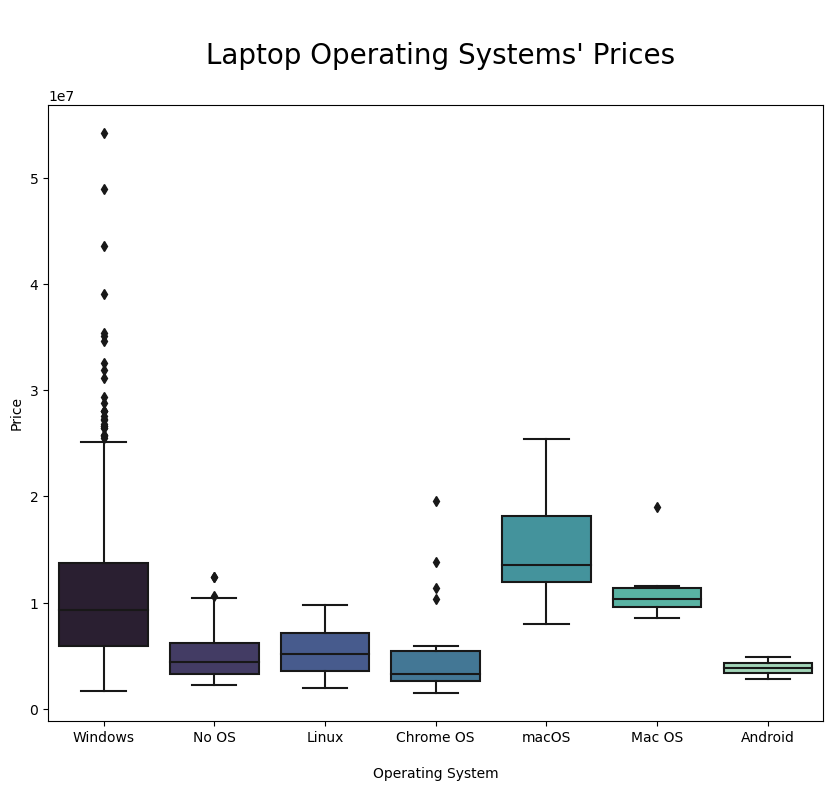

In [28]:
plt.subplots(figsize = (10, 8))

p = sns.boxplot(x = data['Operating System'], y = data['Price'], order = data['Operating System'].value_counts().index, palette = 'mako')

p.axes.set_title("\n Laptop Operating Systems' Prices\n",fontsize=20)
p.axes.set_xlabel("\nOperating System",fontsize=10)
p.axes.set_ylabel("Price",fontsize=10)

# sns.despine(left=True, bottom=True)
plt.show()

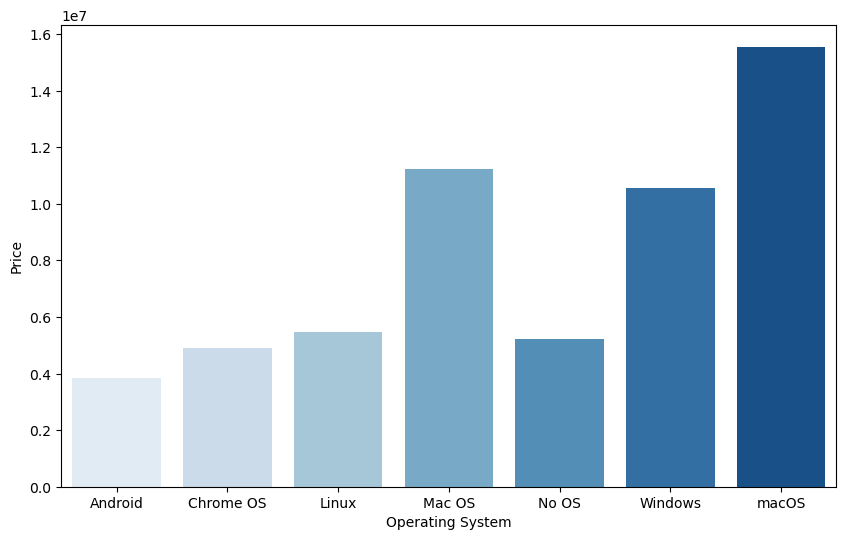

In [29]:
compare_means(data, 'Operating System', 'Price')

## Operating System Version 

In [30]:
data['Operating System Version'].describe()

count     1132
unique       4
top         10
freq      1071
Name: Operating System Version, dtype: object

In [31]:
data['Operating System Version'].value_counts()

10      1071
7         45
X          8
10 S       8
Name: Operating System Version, dtype: int64

In [32]:
data['Operating System Version'].isna().sum()

170

In [33]:
# replace 170 Null value in the data column with the most frequent data (10)
# from sklearn.impute import SimpleImputer

data['Operating System Version'].fillna('Others', inplace = True)
data['Operating System Version'].value_counts()

10        1071
Others     170
7           45
X            8
10 S         8
Name: Operating System Version, dtype: int64

In [34]:
data['Operating System Version'].value_counts().index

Index(['10', 'Others', '7', 'X', '10 S'], dtype='object')

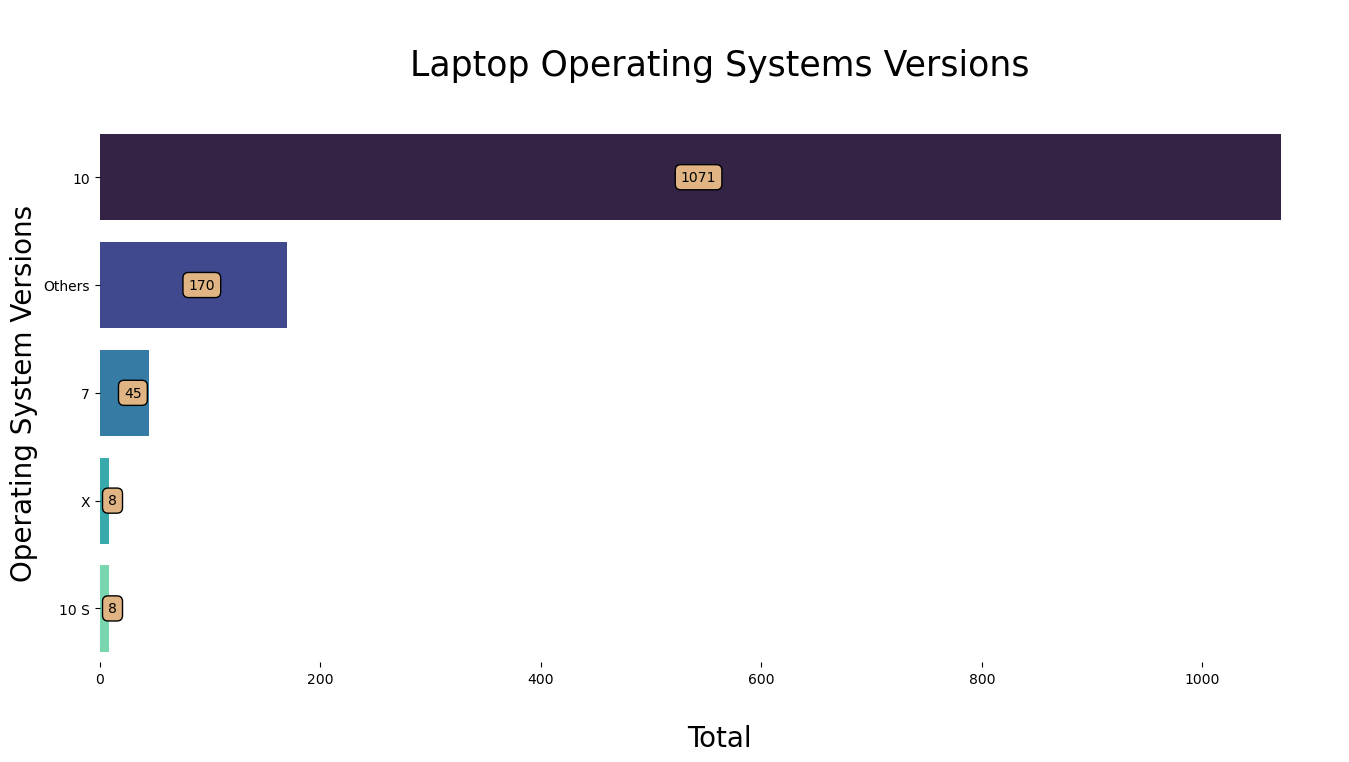

In [35]:
# Bar plot for the number of all the Operating system version
plt.subplots(figsize = (16, 7))

size = 0.5

p = sns.countplot(y = data['Operating System Version'], order = data['Operating System Version'].value_counts().index, linewidth = 3, saturation = 1, palette = 'mako')

p.axes.set_title("\nLaptop Operating Systems Versions\n",fontsize=25)
p.axes.set_ylabel("Operating System Versions",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)

for container in p.containers:
    p.bar_label(container, label_type='center', padding = 6, size = 10,
               bbox = {'boxstyle':'round', 'pad' : 0.4, 'edgecolor' : 'black', "facecolor": "#e0b583"})
    
sns.despine(left = True, bottom = True)
plt.show()

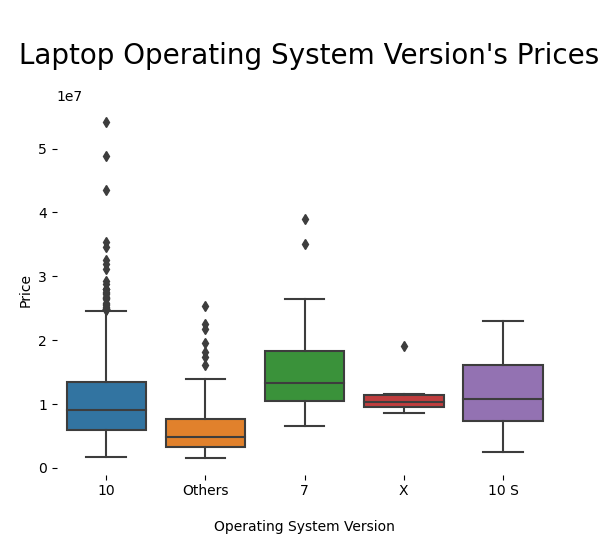

In [36]:
# Box plot for the Price of each Version of the Operating System 
p = sns.boxplot(x = data['Operating System Version'], y = data['Price'], order = data['Operating System Version'].value_counts().index)

p.axes.set_title("\n Laptop Operating System Version's Prices\n",fontsize=20)
p.axes.set_xlabel("\nOperating System Version",fontsize=10)
p.axes.set_ylabel("Price",fontsize=10)

sns.despine(left = True, bottom = True)
plt.show()

### CPU and GPU Manufacturer

In [37]:
data['CPU'].value_counts().index

Index(['Intel Core i5 7200U 2.5GHz', 'Intel Core i7 7700HQ 2.8GHz',
       'Intel Core i7 7500U 2.7GHz', 'Intel Core i7 8550U 1.8GHz',
       'Intel Core i5 8250U 1.6GHz', 'Intel Core i5 6200U 2.3GHz',
       'Intel Core i3 6006U 2GHz', 'Intel Core i7 6500U 2.5GHz',
       'Intel Core i7 6700HQ 2.6GHz', 'Intel Core i3 7100U 2.4GHz',
       ...
       'Intel Core i5 7500U 2.7GHz', 'Intel Core i7 2.8GHz',
       'Intel Core i3 6100U 2.1GHz', 'AMD E-Series E2-9000 2.2GHz',
       'Intel Core i7 2.2GHz', 'Intel Core M M3-6Y30 0.9GHz',
       'AMD A9-Series 9420 2.9GHz', 'Intel Core i3 6006U 2.2GHz',
       'AMD A6-Series 7310 2GHz', 'Intel Xeon E3-1535M v6 3.1GHz'],
      dtype='object', length=118)

In [38]:
data['GPU'].value_counts().index

Index(['Intel HD Graphics 620', 'Intel HD Graphics 520',
       'Intel UHD Graphics 620', 'Nvidia GeForce GTX 1050',
       'Nvidia GeForce GTX 1060', 'Nvidia GeForce 940MX', 'AMD Radeon 530',
       'Intel HD Graphics 500', 'Intel HD Graphics 400',
       'Nvidia GeForce GTX 1070',
       ...
       'Intel HD Graphics 530', 'Nvidia GeForce GTX1080',
       'Nvidia GeForce GTX1050 Ti', 'Nvidia Quadro M620M',
       'Intel Graphics 620', 'AMD Radeon R5 520', 'AMD Radeon R7',
       'Intel HD Graphics 540', 'AMD Radeon 540', 'ARM Mali T860 MP4'],
      dtype='object', length=110)

In [39]:
def extract_mftr(train):
    train['cpum'] = train['CPU'].str.extract(r'^(\w+)')
    train['gpum'] = train['GPU'].str.extract(r'^(\w+)')
    train['cpu_speed'] = train['CPU'].str.split(' ').str[-1]
    train['cpu_speed'] = train['cpu_speed'].str.replace('GHz', '').astype(np.float64)
    return train

data = extract_mftr(data)
data.head()

,Manufacturer,Model Name,Category,Screen Size,Screen,CPU,RAM,Storage,GPU,Operating System,Operating System Version,Weight,Price,cpum,gpum,cpu_speed
0,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,Others,1.37kg,11912523.48,Intel,Intel,2.3
1,Apple,Macbook Air,Ultrabook,"13.3""",1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,Others,1.34kg,7993374.48,Intel,Intel,1.8
2,HP,250 G6,Notebook,"15.6""",Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,Others,1.86kg,5112900.00,Intel,Intel,2.5
3,Apple,MacBook Pro,Ultrabook,"15.4""",IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,Others,1.83kg,22563005.40,Intel,AMD,2.7
4,Apple,MacBook Pro,Ultrabook,"13.3""",IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,Others,1.37kg,16037611.20,Intel,Intel,3.1


In [40]:
data['cpu_speed'].value_counts()

2.50    293
2.80    165
2.70    165
1.60    134
2.30     86
2.00     86
1.80     78
2.60     76
1.10     53
2.40     52
2.90     21
3.00     19
1.20     15
1.44     12
2.20     11
1.50     10
1.30      6
3.60      5
0.90      4
3.10      3
2.10      3
1.90      2
3.20      1
1.00      1
1.92      1
Name: cpu_speed, dtype: int64

In [41]:
data['cpum'].value_counts()

Intel      1239
AMD          62
Samsung       1
Name: cpum, dtype: int64

In [42]:
data['gpum'].value_counts()

Intel     722
Nvidia    399
AMD       180
ARM         1
Name: gpum, dtype: int64

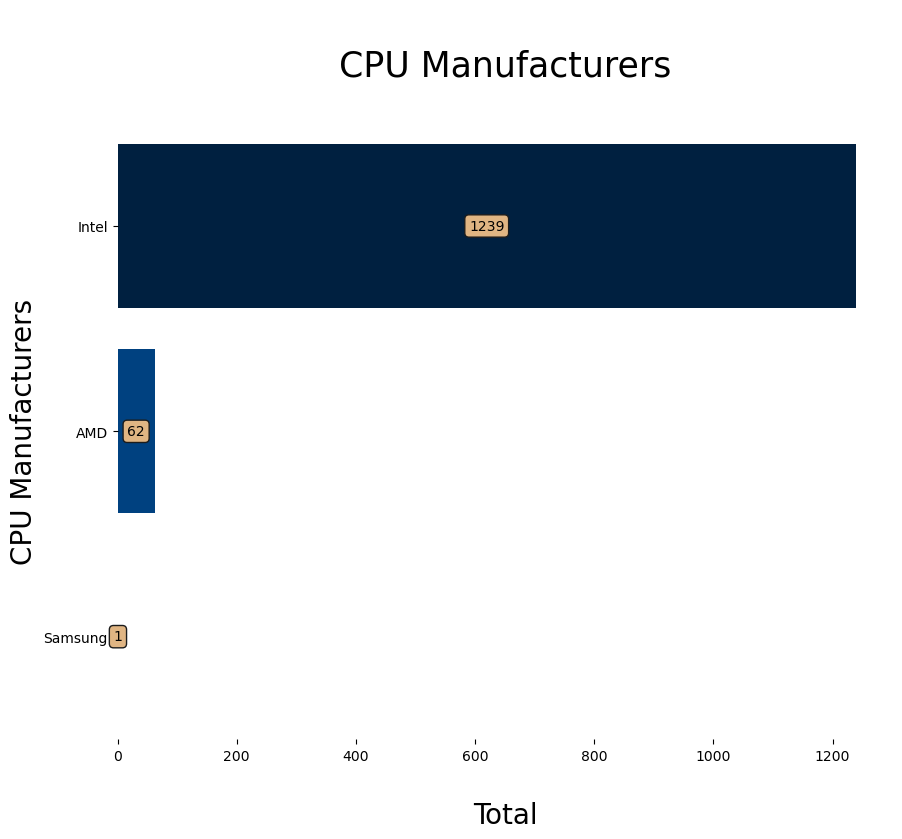

In [43]:
# Plot the countplot of the CPU manufacturer
plt.subplots(figsize = (10, 8))

p = sns.countplot(y = data['cpum'], order = data['cpum'].value_counts().index, palette = 'ocean', saturation = 1)

p.axes.set_title("\nCPU Manufacturers\n",fontsize=25)
p.axes.set_ylabel("CPU Manufacturers",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)

for container in p.containers:
    p.bar_label(container, label_type = 'center', bbox = {'boxstyle' : 'round', 'edgecolor' : '#1c1c1c', 'facecolor': '#e0b583'})
    
    
sns.despine(left = True, bottom = True)
plt.show()

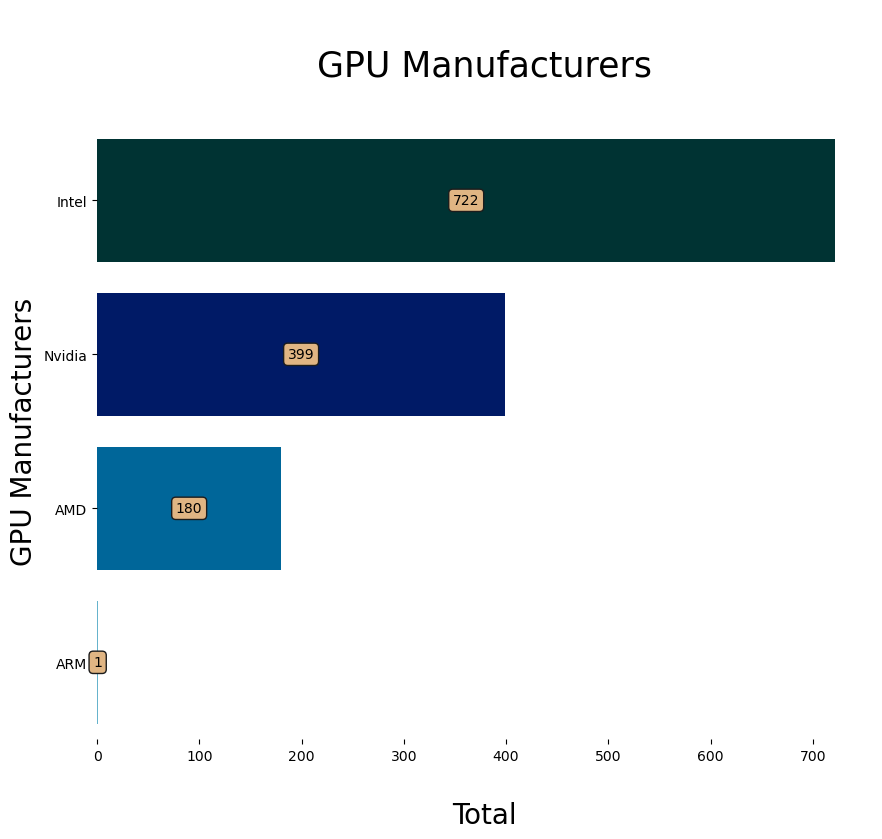

In [44]:
# Plot the countplot of the GPU manufacturer
plt.subplots(figsize = (10, 8))

p = sns.countplot(y = data['gpum'], order = data['gpum'].value_counts().index, palette = 'ocean', saturation = 1)

p.axes.set_title("\nGPU Manufacturers\n",fontsize=25)
p.axes.set_ylabel("GPU Manufacturers",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)

for container in p.containers:
    p.bar_label(container, label_type = 'center', bbox = {'boxstyle' : 'round', 'edgecolor' : '#1c1c1c', 'facecolor': '#e0b583'})
    
    
sns.despine(left = True, bottom = True)
plt.show()

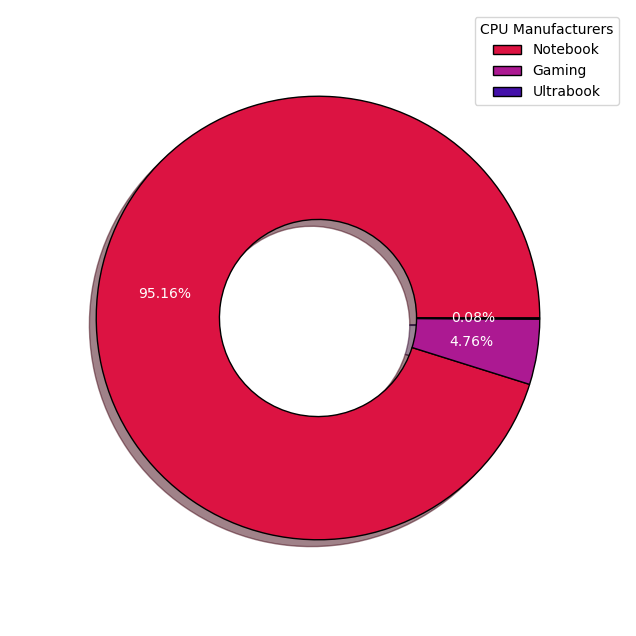

In [45]:
# Pie plot for the percent of each manufacturer of CPU 
plt.subplots(figsize = (12, 8))
size = 0.65
label = 'Intel', 'AMD', 'Samsung'

wedges, texts, autotexts = plt.pie([data['cpum'].value_counts().values[0],
             data['cpum'].value_counts().values[1],
             data['cpum'].value_counts().values[2]],
               explode = (0, 0 ,0),
               autopct = '%.2f%%',
               pctdistance=0.7,
               radius = .9,
               textprops=dict(size = 10, color = 'white'), 
               colors = ['#dc1342', '#ac1992', '#4411aa'],
               shadow = True,
               wedgeprops = dict(linewidth = 1,edgecolor = 'black', width = 0.5)
               )

plt.legend(wedges, labels, loc = 'best', title = 'CPU Manufacturers')
sns.despine(left = True, bottom = True)
plt.show()

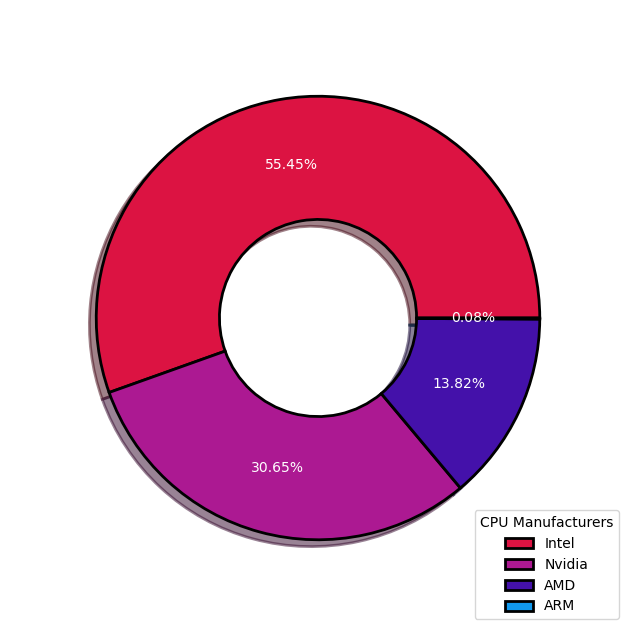

In [46]:
# Pie plot for the percent of each manufacturer of CPU 
plt.subplots(figsize = (12, 8))
label = 'Intel', 'Nvidia', 'AMD', 'ARM'

wedges, texts, autotexts = plt.pie([data['gpum'].value_counts().values[0],
             data['gpum'].value_counts().values[1],
             data['gpum'].value_counts().values[2],
             data['gpum'].value_counts().values[3]],
               explode = (0, 0 ,0, 0),
               autopct = '%.2f%%',
               pctdistance=0.7,
               radius = .9,
               textprops=dict(size = 10, color = 'white'), 
               colors = ['#dc1342', '#ac1992', '#4411aa', '#1199ee'],
               shadow = True,
               wedgeprops = dict(linewidth = 2,edgecolor = 'black', width = 0.5)
               )

plt.legend(wedges, label, loc = 'best', title = 'CPU Manufacturers')
sns.despine(left = True, bottom = True)
plt.show()

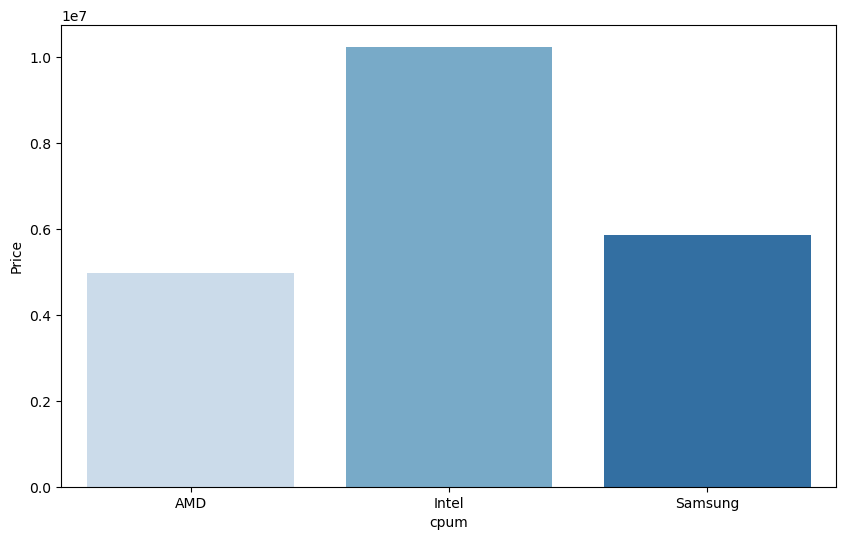

In [47]:
compare_means(data, 'cpum', 'Price')

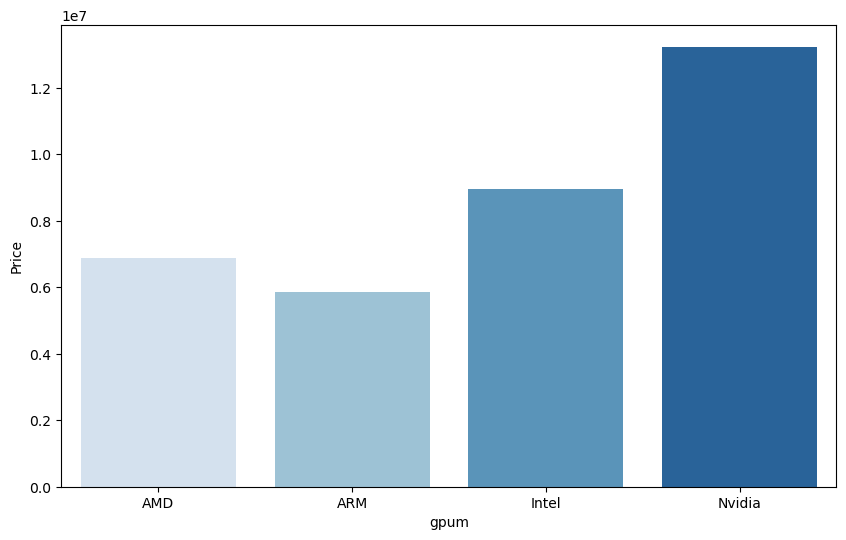

In [48]:
compare_means(data, 'gpum', 'Price')

## Storage 

In [49]:
data[' Storage'].value_counts()

256GB SSD                        412
1TB HDD                          224
500GB HDD                        132
512GB SSD                        118
128GB SSD +  1TB HDD              94
128GB SSD                         76
256GB SSD +  1TB HDD              73
32GB Flash Storage                38
2TB HDD                           16
64GB Flash Storage                15
512GB SSD +  1TB HDD              14
1TB SSD                           14
256GB SSD +  2TB HDD              10
1TB Hybrid                         9
256GB Flash Storage                8
16GB Flash Storage                 7
32GB SSD                           6
1GB SSD                            5
128GB Flash Storage                4
16GB SSD                           3
512GB Flash Storage                2
1TB SSD +  1TB HDD                 2
512GB SSD +  2TB HDD               2
256GB SSD +  500GB HDD             2
128GB SSD +  2TB HDD               2
256GB SSD +  256GB SSD             2
512GB SSD +  256GB SSD             1
5

In [50]:
# Function to extract the storage type and size from the storage
def extract_storage(train):
    train['storage1'] = train[' Storage']
    train['storage1'] = train['storage1'].str.replace('1.0TB', '1TB', regex = True)
    train['storage1'] = train['storage1'].str.replace('1TB','1000GB')
    train['storage1'] = train['storage1'].str.replace('2TB','2000GB')
    train['storage1'] = train['storage1'].str.replace('GB', '')
    train['storage2'] = train['storage1'].str.replace(r' ', '')
    
    storage1 = []
    storage2 = []
    
    for i in train['storage2']:
        if len(re.findall(r'\+', i)) == 1: 
            # Double drive
            one = re.findall(r'(\w+)', i)
            storage1.append(one[0])
            storage2.append(one[1])
        else: 
            # Single drive
            one = re.findall(r'(\w+)', i)
            storage1.append(one[0])
            storage2.append('NaN')
            
    storage1type = []
    storage1size = []
    
    for i in storage1:
        storage1type.append(re.findall(r'(\D\w+)', i)[0])
        storage1size.append(re.findall(r'(\d+)', i)[0])
        
    storage2type = []
    storage2size = []
    
    for i in storage2:
        if i != 'NaN':
            storage2type.append(re.findall(r'(\D\w+)', i)[0])
            storage2size.append(re.findall(r'(\d+)', i)[0])
        else:
            storage2type.append('NaN')
            storage2size.append(0)
    
    train['primarystorage_size'] = storage1size
    train['primarystorage_type'] = storage1type
    train['secondarystorage_size'] = storage2size
    train['secondarystorage_type'] = storage2type
    
    train['primarystorage_size'] = train['primarystorage_size'].astype(np.float64)
    train['secondarystorage_size'] = train['secondarystorage_size'].astype(np.float64)
    
    train.drop(['storage1', 'storage2', ' Storage'], axis = 1, inplace = True)
    train = train.replace({'Nan', np.nan})
    return train

In [51]:
data = extract_storage(data)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1302 entries, 0 to 1301
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Manufacturer              1302 non-null   object 
 1   Model Name                1302 non-null   object 
 2   Category                  1302 non-null   object 
 3   Screen Size               1302 non-null   object 
 4   Screen                    1302 non-null   object 
 5   CPU                       1302 non-null   object 
 6   RAM                       1302 non-null   object 
 7   GPU                       1302 non-null   object 
 8   Operating System          1302 non-null   object 
 9   Operating System Version  1302 non-null   object 
 10  Weight                    1302 non-null   object 
 11  Price                     1302 non-null   float64
 12  cpum                      1302 non-null   object 
 13  gpum                      1302 non-null   object 
 14  cpu_spee

### For the primary storage

In [52]:
data['primarystorage_type'].value_counts()

SSD             842
HDD             375
FlashStorage     75
Hybrid           10
Name: primarystorage_type, dtype: int64

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  """Entry point for launching an IPython kernel.


<AxesSubplot:xlabel='primarystorage_size', ylabel='Count'>

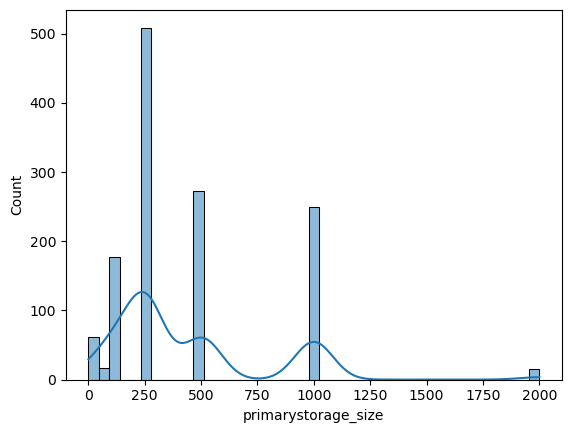

In [53]:
sns.histplot(data['primarystorage_size'], kde = True, palette = 'Ocean')

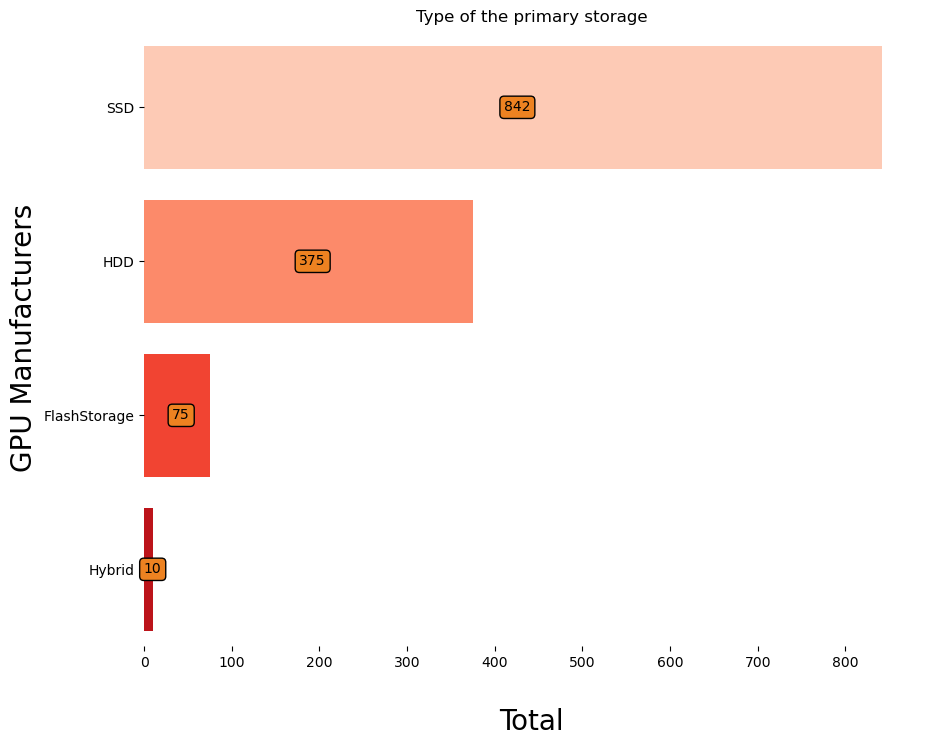

In [54]:
plt.subplots(figsize = (10, 8))
p = sns.countplot(y = data['primarystorage_type'], order = data['primarystorage_type'].value_counts().index, saturation = 1, palette = 'Reds')

p.axes.set_title('Type of the primary storage')
p.axes.set_ylabel("GPU Manufacturers",fontsize=20)
p.axes.set_xlabel("\nTotal",fontsize=20)
p.axes.set_yticklabels(p.get_yticklabels(),rotation = 0)

for container in p.containers:
    p.bar_label(container, padding=3, label_type = 'center',bbox = {'boxstyle':'round', 'edgecolor' : 'black', 'facecolor' : '#ed8221'})
    
sns.despine(left = True, bottom = True)
plt.show()

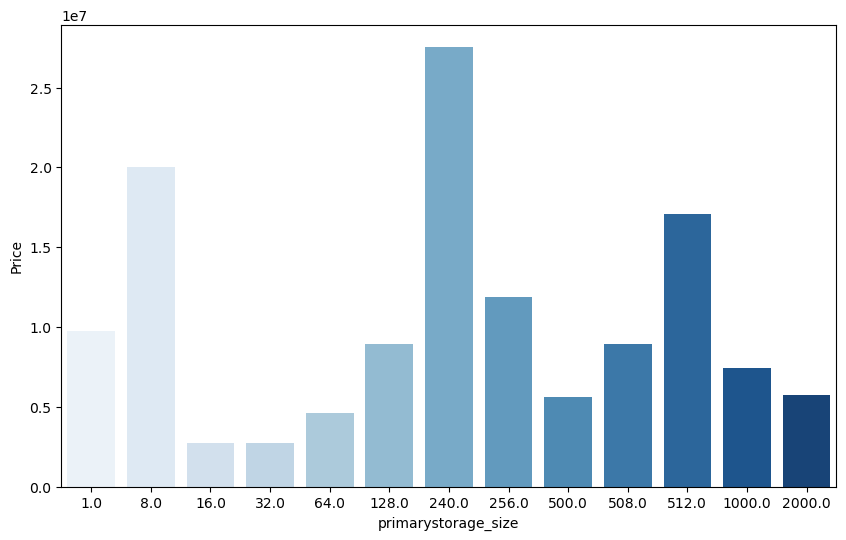

In [55]:
compare_means(data, 'primarystorage_size', 'Price')

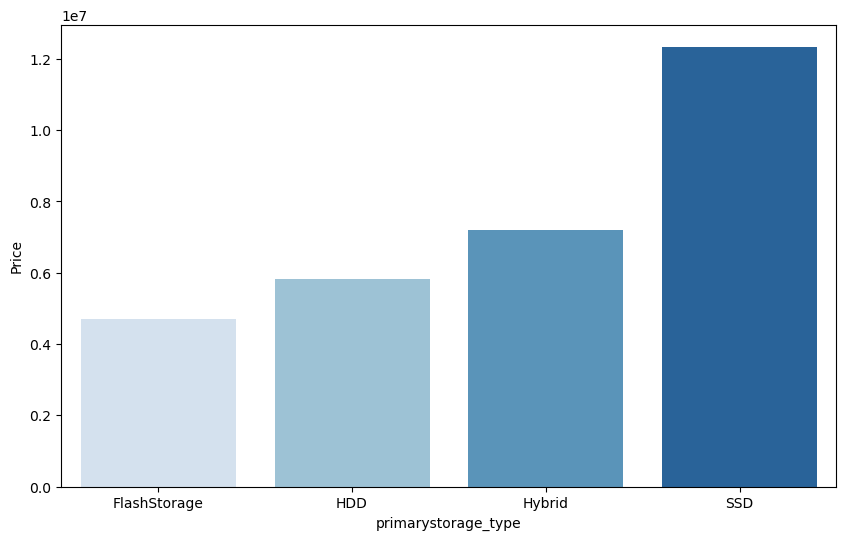

In [56]:
compare_means(data, 'primarystorage_type', 'Price')

### For the secondary storage

In [57]:
second_size = data['secondarystorage_size'].dropna()
second_type = data['secondarystorage_type'].dropna()

In [58]:
second_type.value_counts()

NaN       1095
HDD        201
SSD          4
Hybrid       2
Name: secondarystorage_type, dtype: int64

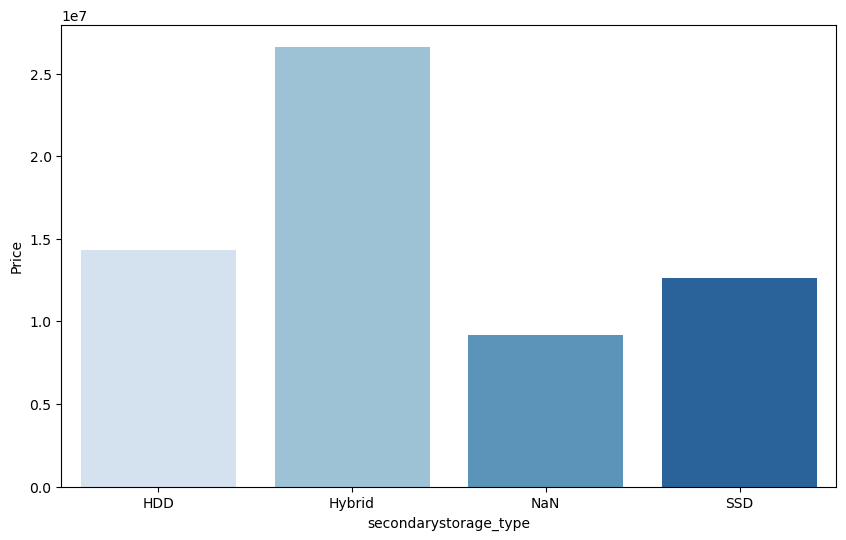

In [59]:
compare_means(data, 'secondarystorage_type', 'Price')

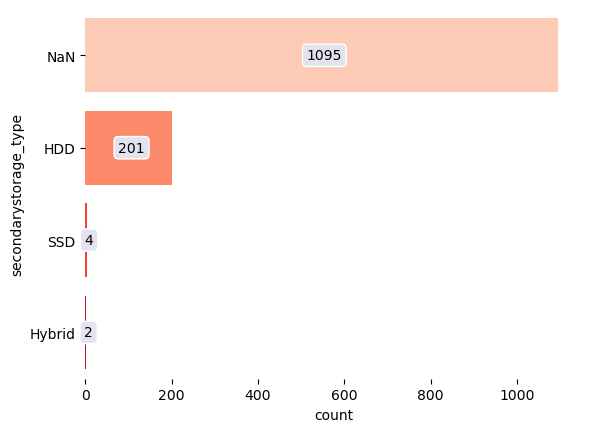

In [60]:
p = sns.countplot(y = second_type, order = second_type.value_counts().index, palette = 'Reds', saturation = 1)
for container in p.containers:
    p.bar_label(container, label_type = 'center', padding = 2, bbox = {'boxstyle' : 'round', 'facecolor' : '#e2e3ee', 'edgecolor' : 'white'})
sns.despine(left = True, bottom = True)
plt.show()
    

## Screen

In [61]:
def extract_screen(train):
    # Extract the resolution(1980x1028,...)
    train['resolution'] = train['Screen'].str.extract(r'(\d+x\d+)')
    # delete the resolution in the screen column to extract screen type
    train['screentype'] = train['Screen'].replace(r'(\d+x\d+)', '', regex = True)
    # Delete the string that denotes the Quality of the screen
    train['screentype'] = train['screentype'].replace(r'(Full HD|Quad HD|Quad HD|\+|/|4K Ultra HD)','', regex = True)
    
    # Extract the column to show if the screen is a touchscreen or not
    train['touchscreen'] = train['screentype'].str.extract(r'(Touchscreen)')
    train['screentype'] = train['screentype'].replace(r'(Touchscreen)', '', regex = True)
    # If the screen is touchscreen, it is 1, else 0
    train['touchscreen'] = train['touchscreen'].replace('Touchscreen', 1)
    train['touchscreen'] = train['touchscreen'].replace(np.nan, 0)
    train['screentype'] = train['screentype'].replace(r' ','', regex = True)
    train['screentype'] = train['screentype'].replace(r'^\s*$', np.nan, regex = True)
    
    train['touchscreen'] = train['touchscreen'].astype(np.int64)
    train = train.drop("Screen",axis = 1)
    return train

In [62]:
data = extract_screen(data)
data.head()

,Manufacturer,Model Name,Category,Screen Size,CPU,RAM,GPU,Operating System,Operating System Version,Weight,...,cpum,gpum,cpu_speed,primarystorage_size,primarystorage_type,secondarystorage_size,secondarystorage_type,resolution,screentype,touchscreen
0,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5 2.3GHz,8GB,Intel Iris Plus Graphics 640,macOS,Others,1.37kg,...,Intel,Intel,2.3,128.0,SSD,0.0,NaN,2560x1600,IPSPanelRetinaDisplay,0
1,Apple,Macbook Air,Ultrabook,"13.3""",Intel Core i5 1.8GHz,8GB,Intel HD Graphics 6000,macOS,Others,1.34kg,...,Intel,Intel,1.8,128.0,FlashStorage,0.0,NaN,1440x900,NaN,0
2,HP,250 G6,Notebook,"15.6""",Intel Core i5 7200U 2.5GHz,8GB,Intel HD Graphics 620,No OS,Others,1.86kg,...,Intel,Intel,2.5,256.0,SSD,0.0,NaN,1920x1080,NaN,0
3,Apple,MacBook Pro,Ultrabook,"15.4""",Intel Core i7 2.7GHz,16GB,AMD Radeon Pro 455,macOS,Others,1.83kg,...,Intel,AMD,2.7,512.0,SSD,0.0,NaN,2880x1800,IPSPanelRetinaDisplay,0
4,Apple,MacBook Pro,Ultrabook,"13.3""",Intel Core i5 3.1GHz,8GB,Intel Iris Plus Graphics 650,macOS,Others,1.37kg,...,Intel,Intel,3.1,256.0,SSD,0.0,NaN,2560x1600,IPSPanelRetinaDisplay,0


In [63]:
# Resolution
data['resolution'].value_counts()

1920x1080    841
1366x768     308
3840x2160     42
3200x1800     27
2560x1440     23
1600x900      23
2560x1600      6
2304x1440      6
2256x1504      6
1920x1200      5
1440x900       4
2880x1800      4
2400x1600      4
2160x1440      2
2736x1824      1
Name: resolution, dtype: int64

<AxesSubplot:xlabel='resolution', ylabel='count'>

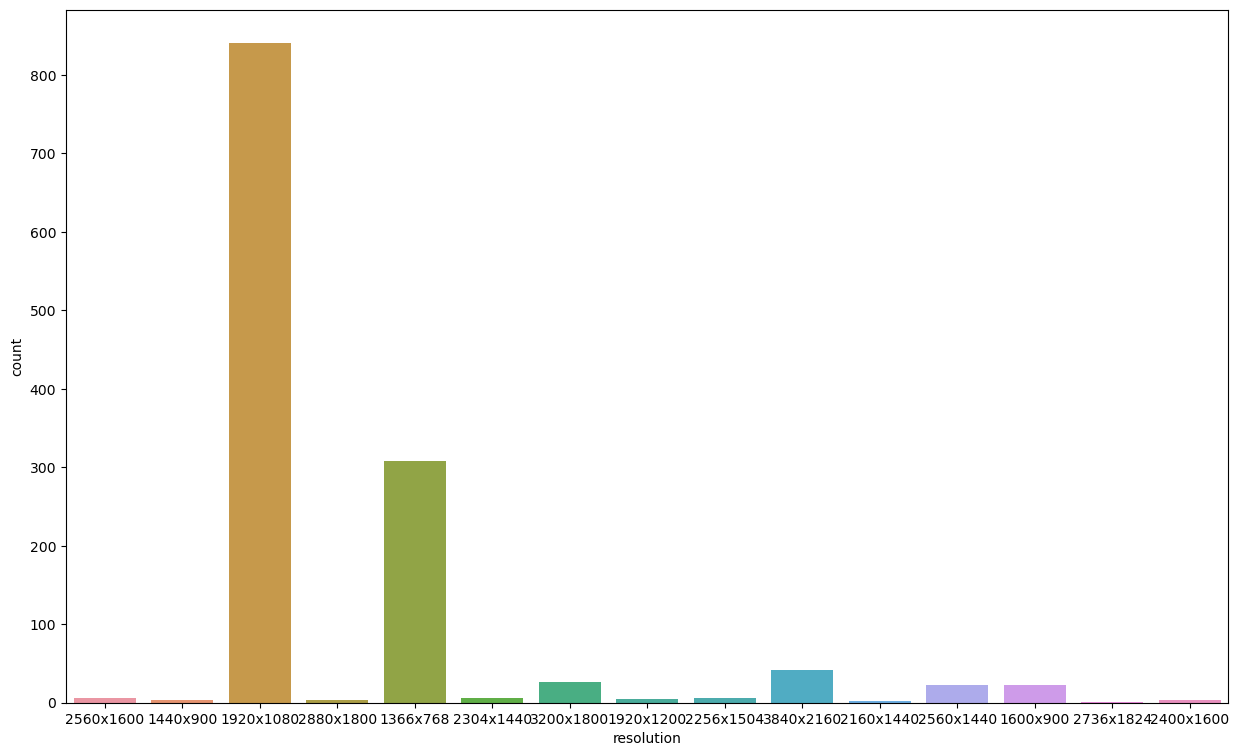

In [64]:
plt.subplots(figsize = (15,9))
sns.countplot(data = data, x = 'resolution')

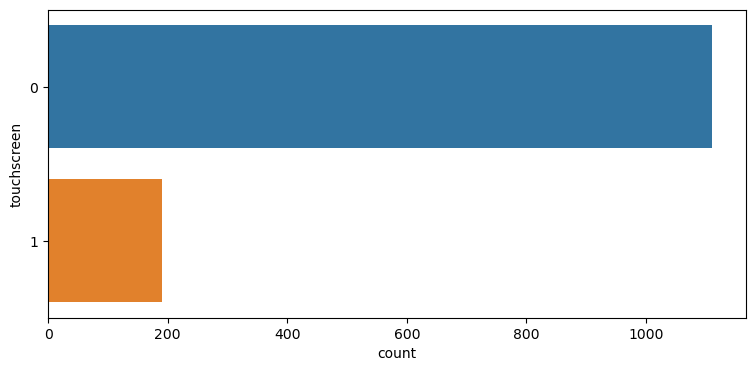

In [65]:
plt.subplots(figsize = (9,4))
sns.countplot(data = data, y = 'touchscreen')
plt.show()

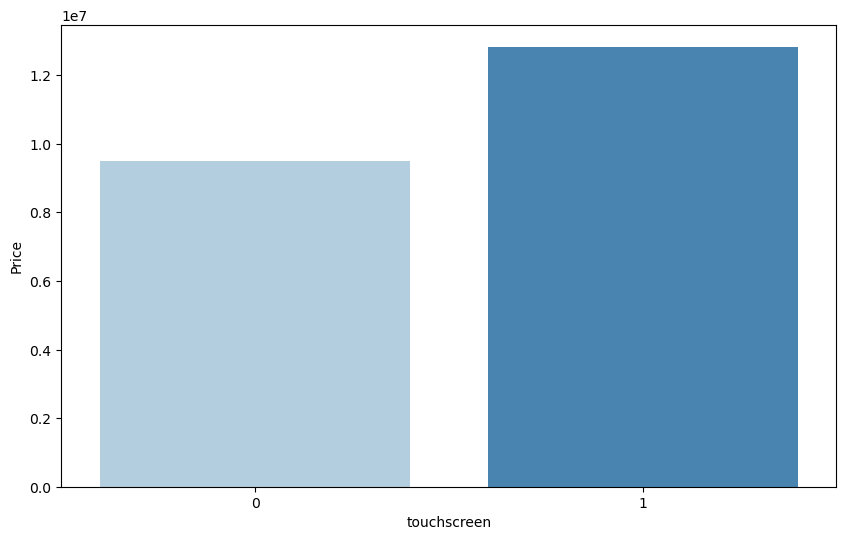

In [66]:
compare_means(data, 'touchscreen', 'Price')

## Weight 

In [67]:
data['Weight'] = data['Weight'].str.replace('kg', '')
data['Weight'] = data['Weight'].str.replace('s', '')
data['Weight'] = data['Weight'].astype(np.float64)

In [68]:
data['Weight'].value_counts()

2.20    126
2.10     58
2.00     45
2.40     44
2.30     40
       ... 
4.50      1
1.14      1
3.80      1
3.25      1
2.34      1
Name: Weight, Length: 171, dtype: int64

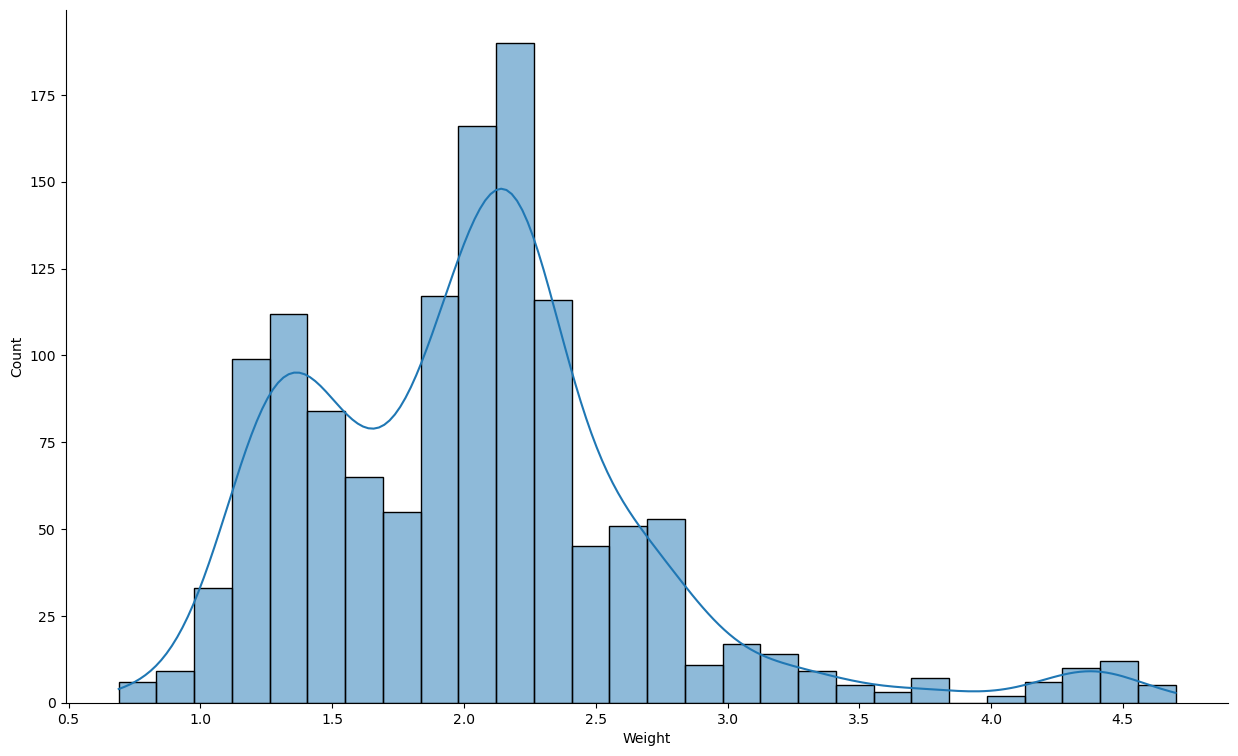

In [69]:
plt.subplots(figsize = (15,9))
sns.histplot(data = data, x = 'Weight', kde = True)
plt.xticks(None)
sns.despine(right = True, top = True)
plt.show()

## Screen Size

In [70]:
data['Screen Size'] = data['Screen Size'].str.replace('"', '')
data['Screen Size'] = data['Screen Size'].astype(np.float64)
data['Screen Size'].value_counts()

15.6    664
14.0    197
13.3    164
17.3    164
12.5     39
11.6     33
12.0      6
13.5      6
13.9      6
12.3      5
10.1      4
15.4      4
15.0      4
13.0      2
18.4      1
17.0      1
14.1      1
11.3      1
Name: Screen Size, dtype: int64

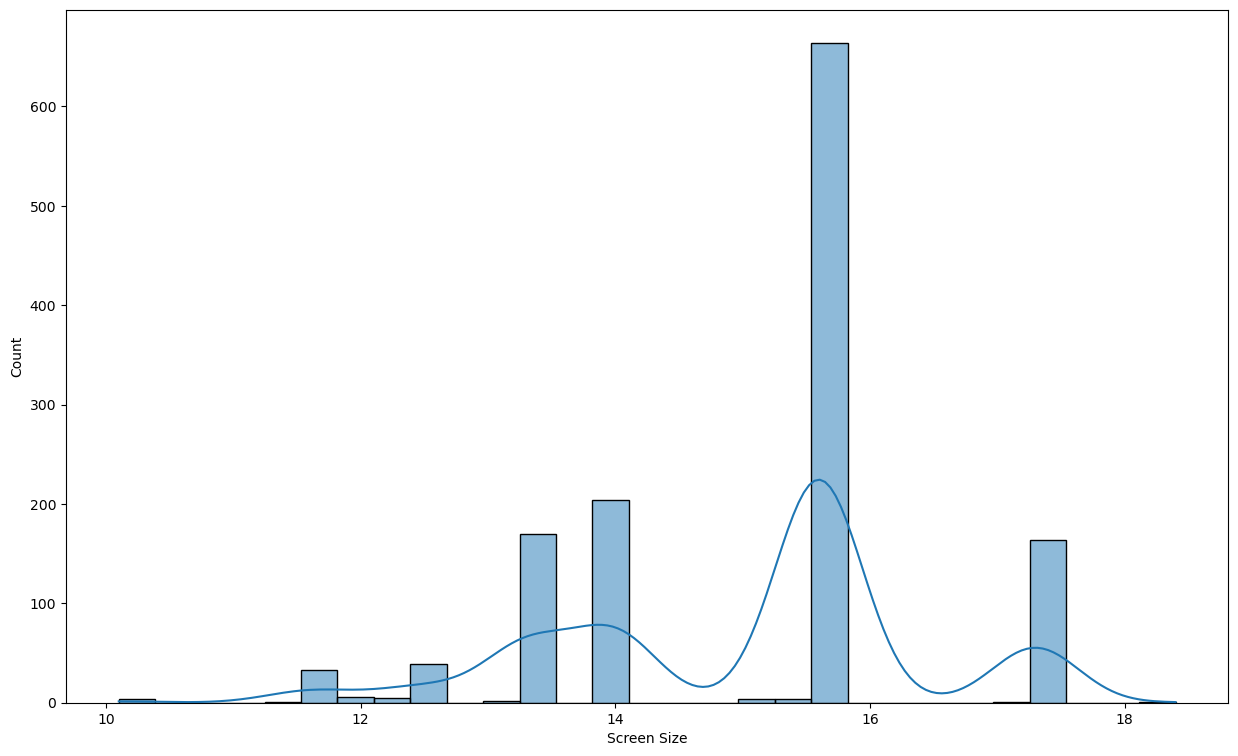

In [71]:
plt.subplots(figsize = (15, 9))
sns.histplot(data = data, x = 'Screen Size', kde = True)
plt.xticks(None)
plt.show()

## RAM

In [72]:
data['RAM'] = data['RAM'].str.replace('GB', '')
data['RAM'] = data['RAM'].astype(np.float64)
data['RAM'].value_counts()

8.0     619
4.0     375
16.0    199
6.0      41
12.0     25
2.0      22
32.0     17
24.0      3
64.0      1
Name: RAM, dtype: int64

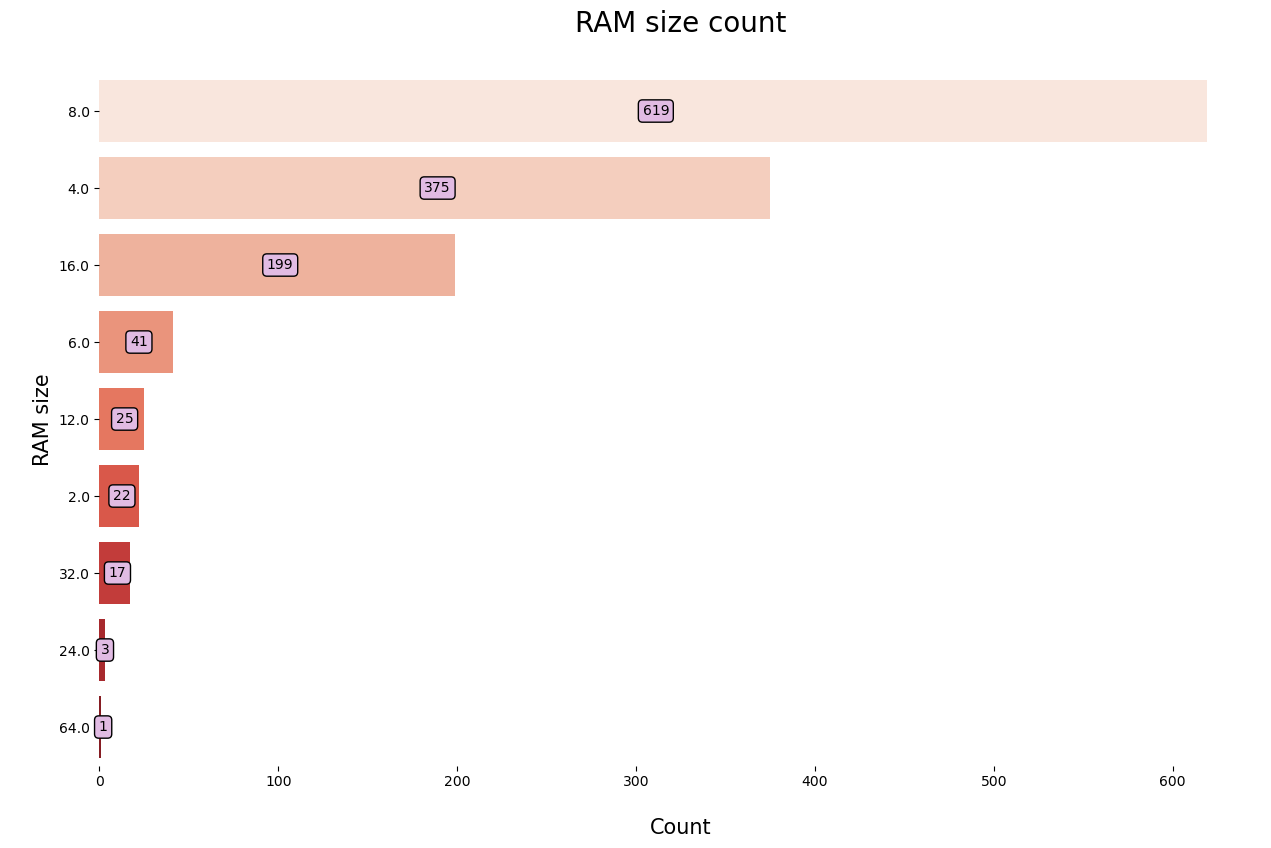

In [73]:
plt.subplots(figsize = (15,9))
p = sns.countplot(y = data['RAM'], order = data['RAM'].value_counts().index, palette = 'Reds')

p.axes.set_title('RAM size count\n', fontsize = 20)
p.axes.set_xlabel('\nCount', fontsize = 15)
p.axes.set_ylabel('\nRAM size', fontsize = 15)

for container in p.containers:
    p.bar_label(container, label_type = 'center', padding = 2, bbox = {'boxstyle' : 'round', 'facecolor' : '#e1bbe3', 'edgecolor' : 'black'})

sns.despine(left = True, bottom = True)
plt.show()

In [74]:
data = data.drop(['CPU', 'GPU'], axis = 1)

In [75]:
data_onehot = data

In [76]:
target = data_onehot['Price']
train = data_onehot.drop(['Price'], axis = 1)
train.shape

(1302, 18)

In [77]:
train = train.drop(['Model Name'],axis = 1)
cols = ['Manufacturer', 'touchscreen','Category', 'Operating System', 'Operating System Version', 
            'cpum', 'gpum', 'primarystorage_type', 'screentype', 'secondarystorage_type', 'resolution']
train = pd.get_dummies(train, columns = cols)
train.shape

(1302, 77)

In [78]:
# Minmax Scaler for numerical columns
# mms = MinMaxScaler()
# num_cols = ['Screen Size', 'RAM', 'Weight', 'cpu_speed', 'primarystorage_size', 'secondarystorage_size']
# train[num_cols] = mms.fit_transform(train[num_cols])
# train.shape

# DATA MODEL

In [79]:
# Linear Regression
# lr = LinearRegression()
# folds = KFold(n_splits = 10, shuffle = True, random_state = 37)
# #lr_score = cross_val_score(lr, train, target, scoring = 'r2', cv = folds)
# params = {
#     'fit_intercept' : ['True', 'False'],
#     'copy_X' : ['True', 'False']
# }
# grid_search = GridSearchCV(lr, params, n_jobs = -1, verbose = 1,cv = folds, scoring = 'r2')
# grid_search.fit(train, target)
# print('The best params of the Linear Regression model: ', grid_search.best_params_, ' with the r2 score of ', grid_search.best_score_)


In [80]:
# Decision Tree Regressor
# dt = DecisionTreeRegressor()
# params = {
#     'max_depth' : [3,5,8,10,15,20],
#     'min_samples_leaf': [5, 10, 15, 20,30],
#     'criterion': ['squared_error', 'friedman_mse', 'absolute_error', 'poisson']
# }
# grid_search = GridSearchCV(dt, params, scoring = 'r2', n_jobs = -1, cv = folds, verbose = 1)
# grid_search.fit(train, target)

# # The best params for the model
# print('The best model of the decision tree: ', grid_search.best_params_, ' with the r2 score of', grid_search.best_score_)

In [81]:
# Best Decision Tree Regressor found performance
dt = DecisionTreeRegressor(criterion = 'friedman_mse', max_depth=20, min_samples_leaf=5)
folds = KFold(n_splits = 10, shuffle = True, random_state = 37)
dt_score = cross_val_score(dt, train, target, scoring = 'r2', cv = folds)

print('The mean score of the Decision Tree model: ', dt_score.mean())
dt_score


The mean score of the Decision Tree model:  0.7372393919767962


array([0.76084776, 0.70483322, 0.68820868, 0.74434579, 0.7936485 ,
       0.7834054 , 0.64370979, 0.80256859, 0.71822356, 0.73260264])

In [82]:
# # Support Vector Machine(bad performace on this problem)
# # Gradient Boosting Regressor
# gdb = GradientBoostingRegressor(learning_rate = 0.098, max_depth=5, loss = 'huber', n_estimators = 150)
# params = {
#     #'learning_rate' : np.arange(0.001, 0.1, 0.001),
#     #'loss' : ['squared_loss', 'absolute_error', 'huber', 'quantile'],
#     #'n_estimators' : np.arange(50, 200, 50),
#     'subsample' : np.arange(0.6, 1, 0.1),
#     'max_features' : ['sqrt', 'log2']
#     #'max_depth' : [3,5,7]
# }
# grid_search = GridSearchCV(gdb, params, cv= folds, n_jobs = -1, verbose = 1, scoring='r2')
# grid_search.fit(train, target)
# # The best params for the model
# print('The best model of the Gradient Boosting Regressor: ', grid_search.best_params_, ' with the r2 score of', grid_search.best_score_)

In [83]:
# Best Gradient Boosting Regressor found performance
# gdb = GradientBoostingRegressor(learning_rate = 0.098, max_depth=5, loss = 'huber', n_estimators = 150, subsample = 0.8)
# gdb_score = cross_val_score(gdb, train, target, scoring = 'r2', cv = folds)

# print('The mean score of the Gradient Boosting model: ', gdb_score.mean())
# gdb_score

In [84]:
# # XGboost
# xgb = XGBRegressor(eta = 0.09, max_depth = 7)
# params = {
#     #'eta' : np.arange(0.001, 0.1, 0.001),
#     'colsample_bytree' : np.arange(0.5,1,0.1),
#     'n_estimators' : np.arange(50, 300, 50),
#     'subsample' : np.arange(0.6, 1, 0.1),
#     #'max_depth' : [3,5,7,9,11]
# }
# grid_search = GridSearchCV(xgb, params, cv= folds, n_jobs = -1, verbose = 1, scoring='r2')
# grid_search.fit(train, target)
# # The best params for the model
# print('The best model of the XGRegressor: ', grid_search.best_params_, ' with the r2 score of', grid_search.best_score_)

In [85]:
# Best XGBRegressor found performance
xgb = XGBRegressor(eta = 0.09, max_depth=7, n_estimators = 200, subsample = 0.8, colsample_bytree = 0.5)
xgb_score = cross_val_score(xgb, train, target, scoring = 'r2', cv = folds)

print('The mean score of the Gradient Boosting model: ', xgb_score.mean())
xgb_score

The mean score of the Gradient Boosting model:  0.8739092836196443


array([0.86003665, 0.78919961, 0.88506564, 0.91118891, 0.89626246,
       0.91192242, 0.86347311, 0.88467001, 0.86552806, 0.87174596])

### Using Optuna for Tuning Hyperparameters 

In [86]:
# Turning off the warning from the optuna and sklearn
import warnings

In [87]:
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [88]:
# def objective(trial):
#     alpha = trial.suggest_float('alpha', 0.01, 1)
#     positive = trial.suggest_categorical('positive', ['True', 'False'])
#     selection = trial.suggest_categorical('selection', ['cyclic', 'random'])
#     l1_ratio = trial.suggest_float('l1_ratio', 0.01, 1)
#     fit_intercept = trial.suggest_categorical('fit_intercept', ['True', 'False'])
#     warm_start = trial.suggest_categorical('warm_start', ['True', 'False'])
    
#     model = ElasticNet(alpha = alpha, positive = positive, selection = selection, warm_start = warm_start, fit_intercept = fit_intercept, l1_ratio=l1_ratio)
    
#     score = cross_val_score(model, train, target, scoring = 'r2', cv = folds, n_jobs=-1)
#     elastic_score = score.mean()
#     return elastic_score

# warnings.filterwarnings("ignore")

# study = optuna.create_study(direction = 'maximize')
# study.optimize(objective, n_trials=300)
# study.best_params

In [89]:
model = ElasticNet(alpha = 0.010092915740905067, positive = True, selection = 'random', warm_start = True,
                   fit_intercept = True, l1_ratio=0.9491721323932588)
    
score = cross_val_score(model, train, target, scoring = 'r2', cv = folds, n_jobs=-1)
print('Mean r2 score of the ElasticNet: ', score.mean())
score

Mean r2 score of the ElasticNet:  0.7751681006174873


array([0.76949823, 0.67598535, 0.78617404, 0.80919106, 0.81452039,
       0.78207547, 0.74893353, 0.71652164, 0.82554393, 0.82323736])

In [90]:
# def objective(trial):
# #     n_estimators = trial.suggest_int('n_estimators', 10, 200)
# #     bootstrap = trial.suggest_categorical('bootstrap', ['True', 'False'])
# #     max_features = trial.suggest_categorical('max_features', ['sqrt', 'log2', None])
# #     min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 3)
# #     criterion = trial.suggest_categorical('criterion', ['absolute_error', 'poisson', 'squared_error', 'friedman_mse'])
# #     warm_start = trial.suggest_categorical('warm_start', ['True', 'False'])
#     max_depth = trial.suggest_int('max_depth', 3,10)
#     ccp_alpha = trial.suggest_float('ccp_alpha', 0, 2.0)
    
#     model = RandomForestRegressor(n_estimators = 182, bootstrap = True, max_features = 'sqrt', 
#                                   warm_start =True, min_samples_leaf = 1, criterion = 'squared_error', max_depth = max_depth, ccp_alpha = ccp_alpha )
    
#     score = cross_val_score(model, train, target, scoring = 'r2', cv = folds, n_jobs=-1)
#     elastic_score = score.mean()
#     return elastic_score

# warnings.filterwarnings("ignore")

# study = optuna.create_study(direction = 'maximize')
# study.optimize(objective, n_trials=150)
# study.best_params

# # The max_depth and ccp_alpha have no impact and improvement for the model

In [91]:
# Best Random Forest Regressor model found
model = RandomForestRegressor(n_estimators = 182, bootstrap = True, max_features = 'sqrt', 
                                  warm_start =True, min_samples_leaf = 1, criterion = 'squared_error')
    
score = cross_val_score(model, train, target, scoring = 'r2', cv = folds, n_jobs=-1)
print('Mean r2 score of the Random Forest: ', score.mean())
score

Mean r2 score of the Random Forest:  0.8507524738021042


array([0.79984206, 0.80524905, 0.88487642, 0.88564076, 0.87787596,
       0.86666812, 0.83424876, 0.83278019, 0.87055101, 0.84979242])

In [92]:
# def objective(trial):
#     n_estimators = trial.suggest_int('n_estimators', 10, 300)
#     boosting_type = trial.suggest_categorical('boosting_type', ['gbdt', 'dart'])
#     min_child_samples = trial.suggest_int('min_child_samples', 10, 40)
#     num_leaves = trial.suggest_int('num_leaves', 20, 50)    
#     subsample = trial.suggest_float('subsample', 0.1, 1.0)
#     #learning_rate = trial.suggest_float('learning_rate', 0.01, 1)
    
#     model = LGBMRegressor(n_estimators = n_estimators, boosting_type = boosting_type,
#                           min_child_samples = min_child_samples, 
#                            num_leaves = num_leaves, subsample = subsample)
    
#     score = cross_val_score(model, train, target, scoring = 'r2', cv = folds, n_jobs=-1)
#     elastic_score = score.mean()
#     return elastic_score

# warnings.filterwarnings("ignore")

# study = optuna.create_study(direction = 'maximize')
# study.optimize(objective, n_trials=150)
# study.best_params


In [93]:
# Best LightGBM Regressor model found
model = LGBMRegressor( n_estimators = 200, boosting_type = 'gbdt',
                          min_child_samples = 11, num_leaves = 27, subsample =  0.7849126441927247)
    
score = cross_val_score(model, train, target, scoring = 'r2', cv = folds, n_jobs=-1)
print('Mean r2 score of the LightGBM: ', score.mean())
score

Mean r2 score of the LightGBM:  0.856176288714015


array([0.87469964, 0.77862853, 0.86950751, 0.90337579, 0.88839212,
       0.88207496, 0.8230519 , 0.85252168, 0.85227434, 0.8372364 ])

In [94]:
def objective(trial):
    eta = trial.suggest_float('eta', 0.01, 1)
    n_estimators = trial.suggest_int('n_estimators', 10, 300)
    max_depth = trial.suggest_int('max_depth', 3, 10)   
    subsample = trial.suggest_float('subsample', 0.1, 1.0)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0.01, 1)
    colsample_bylevel = trial.suggest_float('colsample_bylevel', 0.01, 1)
    gamma = trial.suggest_float('gamma', 0.01, 1)
    tree_method = trial.suggest_categorical('tree_method', ['auto', 'exact', 'approx', 'hist'])
    #max_leaves = trial.suggest_int('max_leaves', 3, 7)
    #min_child_weight = trial.suggest_float('min_child_weight', 0.1, 1) 
    
    model = XGBRegressor(eta = eta, n_estimators = n_estimators, colsample_bylevel = colsample_bylevel, gamma = gamma,
                          max_depth = max_depth, subsample = subsample,colsample_bytree = colsample_bytree, tree_method = tree_method)
    
    score = cross_val_score(model, train, target, scoring = 'r2', cv = folds, n_jobs=-1)
    elastic_score = score.mean()
    return elastic_score

warnings.filterwarnings("ignore")

study = optuna.create_study(direction = 'maximize')
study.optimize(objective, n_trials=100)
study.best_params


{'eta': 0.09019069633058187,
 'n_estimators': 300,
 'max_depth': 8,
 'subsample': 0.88841150548998,
 'colsample_bytree': 0.3579441787401463,
 'colsample_bylevel': 0.6022382770178362,
 'gamma': 0.4094664155126921,
 'tree_method': 'hist'}

In [95]:
# Best XGBRegressor model found
model = XGBRegressor(n_estimators = 264, colsample_bytree = 0.2783108788978701, colsample_bylevel = 0.7557444957235464, 
                     gamma =  0.5989847150597757, eta =0.1127537088060726, max_depth = 7, subsample = 0.5764141501161746,
                     tree_method = 'hist')
    
score = cross_val_score(model, train, target, scoring = 'r2', cv = folds, n_jobs=-1)
print('Mean r2 score of the XBGRegressor: ', score.mean())
score

Mean r2 score of the XBGRegressor:  0.8811598023922969


array([0.84167874, 0.80920984, 0.90060738, 0.92356302, 0.88095936,
       0.92639655, 0.86996097, 0.87526426, 0.89641003, 0.88754787])

In [96]:
demo = XGBRegressor()
demo.get_params().keys()

dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'gamma', 'gpu_id', 'grow_policy', 'importance_type', 'interaction_constraints', 'learning_rate', 'max_bin', 'max_cat_to_onehot', 'max_delta_step', 'max_depth', 'max_leaves', 'min_child_weight', 'missing', 'monotone_constraints', 'n_estimators', 'n_jobs', 'num_parallel_tree', 'predictor', 'random_state', 'reg_alpha', 'reg_lambda', 'sampling_method', 'scale_pos_weight', 'subsample', 'tree_method', 'validate_parameters', 'verbosity'])